# Data Sources

Get data each 5 min  
1h 1D 1W technical indicator are not real : periods are divided by 12 : 5min * 12 = 1h :
- 1h => 5min
- 1D => 24 x 5min = 120 min = 2h
- 1W => 24 x 7 x 5min = 850min = 14h

- Timing
    - Volume Profile : 30s
    - scrap Tweet  : 39s (2*18s)
    - scrap Eco : 27s
    - scrap GLI : ?

## import

In [1]:
import time
from datetime import datetime

# Notebook execution start timestamp
__nb_start_time = time.time()
__nb_start_datetime = datetime.now()
print(f"Notebook start: {__nb_start_datetime.strftime('%Y-%m-%d %H:%M:%S')}")

Notebook start: 2026-01-13 07:59:11


In [2]:
import os
import sys
import re
import time
import math
import random
from datetime import date
from datetime import timedelta
from datetime import timezone
from datetime import datetime
from tzlocal import get_localzone
import requests
import pickle
#import holidays
import json
# Third Party
import pandas as pd
import numpy as np
import requests
# FINANCE
from openbb import obb
import yfinance as yf
import ccxt
from coinmetrics.api_client import CoinMetricsClient
# CHARTS
import ta
from ta.trend import IchimokuIndicator
from ta.momentum import RSIIndicator
from ta.volatility import AverageTrueRange
from ta.volume import VolumeWeightedAveragePrice
import pandas_ta as pta
# PLOT
import matplotlib.pyplot as plt
import matplotlib as mpl
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
sns.set_theme()

from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv())
obb.user.credentials.fmp_api_key = os.getenv("FMP_KEY")
from fredapi import Fred
fred = Fred(api_key=os.getenv("FRED_KEY"))

from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service as ChromeService
from selenium.webdriver import ActionChains
from selenium.webdriver.common.by import By
from selenium.webdriver.common.actions.wheel_input import ScrollOrigin
from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup
import csv
import pytz
from sklearn.metrics import precision_score

## definitions

In [3]:
#yf_eth = yf.Ticker("ETH-USD")
#yf_btc = yf.Ticker("BTC-USD")
#API_GLASSNODE_KEY = os.getenv("API_GLASSNODE_KEY")
ETH_TICK = "ETH/USDT"
BTC_TICK = "BTC/USDT"
BNB_TICK = "BNB/USDT"
FIRST_DATE = "2023-01-01 00:00:00"
LAST_DATE =  "2025-11-01 00:05:00"
TIMEFRAME = "5m"
TIME_STEP = 5 # 5min
T_FACTOR_1 = int(60/TIME_STEP) # 1h
T_FACTOR_2 = int(4*60/TIME_STEP) # 4h
T_FACTOR_3 = int(24*60/TIME_STEP) # 24h
NB_DAYS_FOR_ECO_FORECAST = 1 # adapte if if need more than one day
PATH_DATA = "data/update"
path_save_df_eth = os.path.join(PATH_DATA,  "df_eth_05m.csv")
path_save_df_eth_2 = os.path.join(PATH_DATA, "df_eth_2_05m.csv")
path_save_df_btc = os.path.join(PATH_DATA, "df_btc_05m.csv")
path_save_df_btc_2 = os.path.join(PATH_DATA, "df_btc_2_05m.csv")
path_save_df_bnb = os.path.join(PATH_DATA, "df_bnb_05m.csv")
path_save_df_bnb_2 = os.path.join(PATH_DATA, "df_bnb_2_05m.csv")
path_save_df_eco = os.path.join(PATH_DATA, "df_eco.csv")
path_save_df_feat = os.path.join(PATH_DATA, "df_features_05m.csv")
PATH_ECO_FOREX = os.path.join(PATH_DATA, 'forex_factory_calendar.csv')
# CCXT crypto exchanges declaration
exchange = ccxt.binance({
    'rateLimit': 1000,
    'enableRateLimit': True,
})

kucoin = ccxt.kucoin({
    'rateLimit': 1,
    'enableRateLimit': True,
})

DICT_COINGECKO = {
    "BTC": "bitcoin",
    "ETH": "ethereum",
}


In [4]:
def get_missing(df):
    nb_missing = df.isnull().sum()
    nb_missing = nb_missing.sort_values()
    nb_missing = nb_missing[nb_missing.values > 0]
    print("missing data : ")
    print(nb_missing)
    print("")
    print("on {} samples".format(df.shape[0]))
    return nb_missing

## Download Prices data OHLCV

In [5]:
# params
#ticker = ETH_TICK
#from_datetime = FIRST_DATE
#to_datetime = LAST_DATE

# def
def req_ohlcv(
        exchange,
        ticker,
        timeframe,
        from_datetime,  
        to_datetime=None
    ):
    
    # common constants
    msec = 1000
    minute = 60 * msec
    hour = 60 * minute
    hold = 30

    from_timestamp = exchange.parse8601(from_datetime)

    if to_datetime is None:
        to_timestamp = exchange.milliseconds()
    else:
        to_timestamp = exchange.parse8601(to_datetime)
        

    data = []

    while from_timestamp < to_timestamp:

        try:

            print(exchange.milliseconds(), 'Fetching candles starting from', exchange.iso8601(from_timestamp))
            ohlcvs = exchange.fetch_ohlcv(ticker, timeframe, from_timestamp, params= { 'until': to_timestamp})
            print(exchange.milliseconds(), 'Fetched', len(ohlcvs), 'candles')
            first = ohlcvs[0][0]
            last = ohlcvs[-1][0]
            print('First candle epoch', first, exchange.iso8601(first))
            print('Last candle epoch', last, exchange.iso8601(last))
            timeframe_ms = int((last - first) / (len(ohlcvs)-1))
            from_timestamp += len(ohlcvs) * timeframe_ms
            data += ohlcvs

        except (ccxt.ExchangeError, ccxt.AuthenticationError, ccxt.ExchangeNotAvailable, ccxt.RequestTimeout) as error:

            print('Got an error', type(error).__name__, error.args, ', retrying in', hold, 'seconds...')
            time.sleep(hold)
    
    df = pd.DataFrame(data)
    df.columns = (["Time", "Open", "High", "Low", "Close", "Volume"])

    df['date'] = pd.to_datetime(df['Time'], unit='ms') # -> date object
    df['date'] = df['date'].dt.strftime("%Y-%m-%d %H:%M:%S") # -> String

    return df

def check_data():
    return (
        os.path.isfile(path_save_df_eth) &
        os.path.isfile(path_save_df_btc) &
        os.path.isfile(path_save_df_bnb)
    )

def check_data_2():
    return (
        os.path.isfile(path_save_df_eth_2) &
        os.path.isfile(path_save_df_btc_2) &
        os.path.isfile(path_save_df_bnb_2)
    )


def test_time_continuity(df):
    try:
        assert df.shape[0] == df.dropna().shape[0], "Some data are NaN !"
        diff_time = df["Time"].diff()
        assert np.max(diff_time) == np.min(diff_time), "Time gap!"

        return True
    
    except AssertionError as error:
        print(error)
        return False




    
def req_ohlcv_all(exchange, first_date=FIRST_DATE, last_date=LAST_DATE):

    df_eth = req_ohlcv(
        exchange,
        ETH_TICK,
        TIMEFRAME,
        first_date,  
        last_date,
    )

    df_eth.drop_duplicates(subset=['Time'], inplace=True, ignore_index=True)

    df_btc = req_ohlcv(
            exchange,
            BTC_TICK,
            TIMEFRAME,
            first_date,  
            last_date,
    )

    df_btc.drop_duplicates(subset=['Time'], inplace=True, ignore_index=True)
 
    df_bnb = req_ohlcv(
            exchange,
            BNB_TICK,
            TIMEFRAME,
            first_date,  
            last_date,
    )

    df_bnb.drop_duplicates(subset=['Time'], inplace=True, ignore_index=True)

    return df_eth, df_btc, df_bnb

def merge_ohlcv_data(df_old, df_new):

    # Merge old with new data 
    df = pd.concat([df_old, df_new], ignore_index=True)
    print("df_old.shape: ", df_old.shape)
    print("df_new.shape: ", df_new.shape)
    print("Before : df.shape: ", df.shape)
    df = df.drop_duplicates(
        subset=["date"], keep="last", ignore_index=True)
    print("After : df.shape: ", df.shape)
    return df



def get_ohlcv_all(exchange, path_save_df_eth, path_save_df_btc, path_save_df_bnb):
    """
    Get prices from disk and from exchange if update needed
    """
    # reload from disk
    print("Reload data binance exchange from disk...")
    df_eth = pd.read_csv(path_save_df_eth)
    df_eth.drop_duplicates(subset=['Time'], inplace=True, ignore_index=True)

    df_btc = pd.read_csv(path_save_df_btc)
    df_btc.drop_duplicates(subset=['Time'], inplace=True, ignore_index=True)

    df_bnb = pd.read_csv(path_save_df_bnb)
    df_bnb.drop_duplicates(subset=['Time'], inplace=True, ignore_index=True)

    # need update ?
    old_timestamp = df_eth.iloc[-1]["Time"]
    new_timestamp = exchange.parse8601(LAST_DATE)

    if old_timestamp < new_timestamp:
        print("New data to download...")
        # data to download
        df_eth_new, df_btc_new, df_bnb_new = req_ohlcv_all(
            exchange, first_date=df_eth.iloc[-1]["date"])
        df_eth = merge_ohlcv_data(df_eth, df_eth_new)
        df_btc = merge_ohlcv_data(df_btc, df_btc_new)
        df_bnb = merge_ohlcv_data(df_bnb, df_bnb_new)
        # save on disk
        df_eth.to_csv(path_save_df_eth, index=False)
        df_btc.to_csv(path_save_df_btc, index=False)
        df_bnb.to_csv(path_save_df_bnb, index=False)
    
    return df_eth, df_btc, df_bnb

In [6]:
data_ok = check_data()
print(data_ok)

if not data_ok:
    
    df_eth, df_btc, df_bnb = req_ohlcv_all(exchange)

    # save on disk
    df_eth.to_csv(path_save_df_eth, index=False)
    df_btc.to_csv(path_save_df_btc, index=False)
    df_bnb.to_csv(path_save_df_bnb, index=False)

else:

    df_eth, df_btc, df_bnb = get_ohlcv_all(
        exchange,
        path_save_df_eth,
        path_save_df_btc,
        path_save_df_bnb
    )

print("df_eth: ", df_eth.shape)
print("df_btc: ", df_btc.shape)
print("df_bnb: ", df_bnb.shape)

True
Reload data binance exchange from disk...
df_eth:  (298065, 7)
df_btc:  (298065, 7)
df_bnb:  (298065, 7)


In [7]:
#test_time_continuity(df_eth)

In [8]:

data_ok_2 = check_data_2()

if not data_ok_2:

    df_eth_2 = req_ohlcv(
            kucoin,
            ETH_TICK,
            TIMEFRAME,
            FIRST_DATE,  
            LAST_DATE,
    )
    time.sleep(10)
    df_btc_2 = req_ohlcv(
            kucoin,
            BTC_TICK,
            TIMEFRAME,
            FIRST_DATE,  
            LAST_DATE,
    )
    time.sleep(10)
    df_bnb_2 = req_ohlcv(
            kucoin,
            BNB_TICK,
            TIMEFRAME,
            FIRST_DATE,  
            LAST_DATE,
    )

    # save on disk
    df_eth_2.to_csv(path_save_df_eth_2, index=False)
    df_btc_2.to_csv(path_save_df_btc_2, index=False)
    df_bnb_2.to_csv(path_save_df_bnb_2, index=False)

else:
    print("Reload data kucoin exchange from disk...")

    df_eth_2, df_btc_2, df_bnb_2 = get_ohlcv_all(
        exchange,
        path_save_df_eth_2,
        path_save_df_btc_2,
        path_save_df_bnb_2,
    )

print("df_eth kucoin: ", df_eth_2.shape)
print("df_btc kucoin: ", df_btc_2.shape)
print("df_bnb kucoin: ", df_bnb_2.shape)



Reload data kucoin exchange from disk...
Reload data binance exchange from disk...
df_eth kucoin:  (298082, 7)
df_btc kucoin:  (298082, 7)
df_bnb kucoin:  (298082, 7)


In [9]:
assert df_eth["Time"].values[0] == df_eth_2["Time"].values[0], "Time reference (first) must be the same!"

In [10]:
def get_unique(df_):
    d_time = np.diff(df_["Time"].values)
    #np.max(d_time) == np.min(d_time)
    unique_val, unique_inv, unique_counts = np.unique(d_time, return_inverse=True, return_counts=True)
    print(unique_val)
    print(unique_counts)
    print(unique_inv)
    return unique_val, unique_counts, unique_inv

In [11]:
def add_nb_time(df_in):
    """
    modify index to be the n-th time-step from first time.
    so a gap in time is reflected into index.
    add nb_time columns (maybe useless).
    """
    df = df_in.copy()
    delta_min = df["Time"].diff().value_counts().index[0]
    df["nb_time"] = ((df["Time"] - df["Time"].values[0]) / delta_min).astype(np.int64)
    df.index = df["nb_time"].values

    list_index = (
        list(set(list(range(df["nb_time"].values[-1]))) 
             - set(list(df["nb_time"].values)))
    )


    return df, list_index

In [12]:
def fill_time_gap(df_in, df_2):
    """
    Binance have some time gap into 1h data, so we have to merge with another 
    exchange data source (kucoin)
    So we use all prices of kucoin for missing dates
    Also, we add estimate unkonwn binance volumes in proportion of previous 
    "hour" known volumes from the two exchanges.

    """
    df = df_in.copy()
    if not test_time_continuity(df):
        if test_time_continuity(df_2):
            # modify index to be n-th time-step in absolute from first time
            df, list_index = add_nb_time(df)

            df_mix = df_2.copy()
            df_mix.loc[df.index] = df

            # correct volumes values : 
            # new vol_t =  vol_t(exchage 2) * vol_t-1(exch 1) / vol_t-1(exch 2)
            for index in list_index:
                print(f"Correcting volume index {index}")
                df_mix.at[index, "Volume"] = (
                    df_mix.at[index-1, "Volume"] 
                    / df_2.at[index-1, "Volume"]
                    * df_mix.at[index, "Volume"]
                )

            if not test_time_continuity(df_mix):
                raise Exception("Error no good mixed data")
            return df_mix
            
        else:
            raise Exception("Error good input data 2")
    else:
        return df

In [13]:
def fill_time_gap_interp(df_in, df_2):
    """
    Imputation of ohlcv CCTX nan data : 
    Binance have some time gap into 1h data, so we have to merge with another 
    exchange data source (kucoin) 
        So we use all prices of kucoin for missing dates
        Also, we add estimate unkonwn binance volumes in proportion of previous 
        "hour" known volumes from the two exchanges.

    If kucoin have also time gap ! OMG!
        So we use all prices of kucoin for missing dates
        If also Nan for kucoin, we interpolate (linear) binance data with Binance data only
        Nan & Zero volumes are interpolate also (unlike former fill_time_gap...) with Binance data only
    """
    df = df_in.copy()
    if not test_time_continuity(df):
        if test_time_continuity(df_2):
            # modify index to be n-th time-step in absolute from first time
            df, list_index = add_nb_time(df)

            df_mix = df_2.copy()
            df_mix.loc[df.index] = df

            # correct volumes values : 
            # new vol_t =  vol_t(exchage 2) * vol_t-1(exch 1) / vol_t-1(exch 2)
            for index in list_index:
                print(f"Correcting volume index {index}")
                df_mix.at[index, "Volume"] = (
                    df_mix.at[index-1, "Volume"] 
                    / df_2.at[index-1, "Volume"]
                    * df_mix.at[index, "Volume"]
                )

            if not test_time_continuity(df_mix):
                raise Exception("Error no good mixed data")
            return df_mix
            
        else:
            #raise Exception("Error good input data 2")

            # two exchanges have nan values !!! OMG!!!
            # use interpolate
            df, l_index = add_nb_time(df)
            df_2, l_index_2 = add_nb_time(df_2)
            new_index = np.array(range(max(df["nb_time"])+1))
            df = df.reindex(new_index)
            df_2 = df_2.reindex(new_index)
            df_mix = df.join(df_2, rsuffix='_2')
            b_nan = df_mix["Open"].isna()
            df_mix.loc[b_nan, "Open"] = df_mix.loc[b_nan, "Open_2"]
            df_mix.loc[b_nan, "High"] = df_mix.loc[b_nan, "High_2"]
            df_mix.loc[b_nan, "Low"] = df_mix.loc[b_nan, "Low_2"]
            df_mix.loc[b_nan, "Close"] = df_mix.loc[b_nan, "Close_2"]
            df_mix.loc[b_nan, "Time"] = df_mix.loc[b_nan, "Time_2"]
            df_mix.loc[b_nan, "date"] = df_mix.loc[b_nan, "date_2"]
            df_mix.loc[b_nan, "nb_time"] = df_mix.loc[b_nan, "nb_time_2"]

            # special volume zero :
            df_mix.loc[df_mix["Volume"] <= 0, "Volume"] = np.nan

            # interpolate 
            df_mix["Open"] = df_mix["Open"].interpolate()
            df_mix["High"] = df_mix["High"].interpolate()
            df_mix["Low"] = df_mix["Low"].interpolate()
            df_mix["Close"] = df_mix["Close"].interpolate()
            df_mix["Volume"] = df_mix["Volume"].interpolate()
            df_mix["Time"] = df_mix["Time"].interpolate()
            df_mix["nb_time"] = df_mix["nb_time"].interpolate()

            # Date
            df_mix['date'] = pd.to_datetime(df_mix['Time'], unit='ms') # -> date object
            df_mix['date'] = df_mix['date'].dt.strftime("%Y-%m-%d %H:%M:%S") # -> String

            # keep good col only
            # Time	Open	High	Low	Close	Volume	date	nb_time
            df_mix = df_mix[["Time",	"Open",	"High",	"Low",	
                            "Close",	"Volume",	"date",	"nb_time"]]
            
            if not test_time_continuity(df_mix):
                raise Exception("Error no good interpolated data")
            return df_mix

    else:
        return df

In [14]:
#df_eth = fill_time_gap(df_eth, df_eth_2)
#df_btc = fill_time_gap(df_btc, df_btc_2)
#df_bnb = fill_time_gap(df_bnb, df_bnb_2)

df_eth = fill_time_gap_interp(df_eth, df_eth_2)
df_btc = fill_time_gap_interp(df_btc, df_btc_2)
df_bnb = fill_time_gap_interp(df_bnb, df_bnb_2)

Time gap!
Correcting volume index 23776
Correcting volume index 23777
Correcting volume index 23778
Correcting volume index 23779
Correcting volume index 23780
Correcting volume index 23781
Correcting volume index 23782
Correcting volume index 23783
Correcting volume index 24016
Correcting volume index 23768
Correcting volume index 23769
Correcting volume index 23770
Correcting volume index 23771
Correcting volume index 23772
Correcting volume index 23773
Correcting volume index 23774
Correcting volume index 23775
Time gap!
Correcting volume index 23776
Correcting volume index 23777
Correcting volume index 23778
Correcting volume index 23779
Correcting volume index 23780
Correcting volume index 23781
Correcting volume index 23782
Correcting volume index 23783
Correcting volume index 24016
Correcting volume index 23768
Correcting volume index 23769
Correcting volume index 23770
Correcting volume index 23771
Correcting volume index 23772
Correcting volume index 23773
Correcting volume in

In [15]:
assert test_time_continuity(df_eth) and test_time_continuity(df_btc) and test_time_continuity(df_bnb) 

## Merge everything

In [16]:
def add_col_suffix(df_in, suffix):
    df = df_in.copy()
    dict_col = {}
    for col in df.columns:
        #print(col)
        if col != "Time":
            dict_col[col] = col + suffix
    #print(dict_col)
    #print(df)
    return df.rename(columns=dict_col)


In [17]:
# df_feat 
df_feat = df_eth.copy()
# merge BTC
df_feat = df_feat.merge(
    df_btc, 
    how='left', 
    left_on='Time', 
    right_on='Time', 
    suffixes=("_ETH", "_BTC")
)
# merge BNB
df_bnb_final = add_col_suffix(df_bnb, "_BNB")
df_feat = df_feat.merge(
    df_bnb_final, 
    how='left', 
    left_on='Time', 
    right_on='Time', 
    suffixes=("_ETH", "_BNB")
)

df_feat.shape

(298082, 19)

## Add price action indicators

### Ichimoku 1h 1D 1W

In [18]:
def add_ichimoku(df):
    """
    Create & add ichimoku data at different ranges : 1h 1D 1W
    Take timestep 1h data as input only

    Ex: df_out = add_ichimoku(df_in)
    
    """

    df_out = df.copy()

    indic_ichi = IchimokuIndicator(
        high=df["High"], 
        low=df["Low"], 
        visual=True
    )
    df_out["ichi_cloud_a"] = indic_ichi.ichimoku_a()
    df_out["ichi_cloud_b"] = indic_ichi.ichimoku_b()
    df_out["ichi_kijun"] = indic_ichi.ichimoku_base_line()
    df_out["ichi_tenkan"] = indic_ichi.ichimoku_conversion_line()

    indic_ichi_1 = IchimokuIndicator(
        high=df["High"], 
        low=df["Low"], 
        visual=True,
        window1=9*T_FACTOR_1,
        window2=26*T_FACTOR_1,
        window3=52*T_FACTOR_1,
    )
    df_out["ichi_cloud_a_1"] = indic_ichi_1.ichimoku_a()
    df_out["ichi_cloud_b_1"] = indic_ichi_1.ichimoku_b()
    df_out["ichi_kijun_1"] = indic_ichi_1.ichimoku_base_line()
    df_out["ichi_tenkan_1"] = indic_ichi_1.ichimoku_conversion_line()

    indic_ichi_2 = IchimokuIndicator(
        high=df["High"], 
        low=df["Low"], 
        visual=True,
        window1=9*T_FACTOR_2,
        window2=26*T_FACTOR_2,
        window3=52*T_FACTOR_2,
    )
    df_out["ichi_cloud_a_2"] = indic_ichi_2.ichimoku_a()
    df_out["ichi_cloud_b_2"] = indic_ichi_2.ichimoku_b()
    df_out["ichi_kijun_2"] = indic_ichi_2.ichimoku_base_line()
    df_out["ichi_tenkan_2"] = indic_ichi_2.ichimoku_conversion_line()

    indic_ichi_3 = IchimokuIndicator(
        high=df["High"], 
        low=df["Low"], 
        visual=True,
        window1=9*T_FACTOR_3,
        window2=26*T_FACTOR_3,
        window3=52*T_FACTOR_3,
    )
    df_out["ichi_cloud_a_3"] = indic_ichi_3.ichimoku_a()
    df_out["ichi_cloud_a_3"].ffill(inplace=True)
    df_out["ichi_cloud_b_3"] = indic_ichi_3.ichimoku_b()
    df_out["ichi_kijun_3"] = indic_ichi_3.ichimoku_base_line()
    df_out["ichi_tenkan_3"] = indic_ichi_3.ichimoku_conversion_line()
    
    return df_out

df_eth = add_ichimoku(df_eth)
df_btc = add_ichimoku(df_btc)

/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_67483/1675705743.py:57: ChainedAssignmentError: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
When using the Copy-on-Write mode, such inplace method never works to update the original DataFrame or Series, because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' instead, to perform the operation inplace on the original object.


  df_out["ichi_cloud_a_3"].ffill(inplace=True)
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_67483/1675705743.py:57: ChainedAssignmentError: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
When using the Copy-on-Write mode, such inplace method never works to update the original DataFrame or Series, because the inte

### RSI 14  1h 1D 1W

In [19]:

# RSIIndicator(close: pandas.core.series.Series, window: int = 14, fillna: bool = False)
def add_rsi(df, n=14):
    df_out = df.copy()
    df_out["rsi_0"] = RSIIndicator(df["High"], window=n).rsi()
    df_out["rsi_1"] = RSIIndicator(df["High"], window=n*T_FACTOR_1).rsi()
    df_out["rsi_2"] = RSIIndicator(df["High"], window=n*T_FACTOR_2).rsi()
    df_out["rsi_3"] = RSIIndicator(df["High"], window=n*T_FACTOR_3).rsi()
    return df_out


df_eth = add_rsi(df_eth)
df_btc = add_rsi(df_btc)
df_eth

,Time,Open,High,Low,Close,Volume,date,ichi_cloud_a,ichi_cloud_b,ichi_kijun,...,ichi_kijun_2,ichi_tenkan_2,ichi_cloud_a_3,ichi_cloud_b_3,ichi_kijun_3,ichi_tenkan_3,rsi_0,rsi_1,rsi_2,rsi_3
0,1672531200000,1196.13,1196.32,1195.65,1196.32,334.5592,2023-01-01 00:00:00,2605.991202,2605.118412,NaN,...,NaN,NaN,2607.007592,2539.292551,NaN,NaN,NaN,NaN,NaN,NaN
1,1672531500000,1196.31,1196.69,1194.90,1195.38,682.3876,2023-01-01 00:05:00,2605.991202,2605.118412,NaN,...,NaN,NaN,2607.007592,2539.292551,NaN,NaN,NaN,NaN,NaN,NaN
2,1672531800000,1195.38,1195.81,1194.55,1194.55,228.9387,2023-01-01 00:10:00,2605.991202,2605.118412,NaN,...,NaN,NaN,2607.007592,2539.292551,NaN,NaN,NaN,NaN,NaN,NaN
3,1672532100000,1194.55,1195.98,1194.31,1195.98,601.8903,2023-01-01 00:15:00,2605.991202,2605.118412,NaN,...,NaN,NaN,2607.007592,2539.292551,NaN,NaN,NaN,NaN,NaN,NaN
4,1672532400000,1195.98,1196.37,1195.97,1196.06,144.8048,2023-01-01 00:20:00,2605.991202,2605.118412,NaN,...,NaN,NaN,2607.007592,2539.292551,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298077,1761954300000,3858.00,3858.77,3852.01,3852.18,429.9622,2025-10-31 23:45:00,3863.877500,3857.600000,3858.590,...,3956.74,3793.045,4292.132500,4385.890000,4095.0,3966.86,47.144726,50.267614,48.917537,49.503404
298078,1761954600000,3852.19,3852.19,3849.42,3849.42,587.7892,2025-10-31 23:50:00,3862.972500,3857.600000,3858.300,...,3956.74,3793.045,4292.132500,4385.890000,4095.0,3966.86,37.643702,49.836389,48.813976,49.486539
298079,1761954900000,3849.43,3849.45,3847.94,3847.99,580.9754,2025-10-31 23:55:00,3861.960000,3857.600000,3857.560,...,3956.74,3793.045,4292.132500,4385.890000,4095.0,3966.86,34.523640,49.657936,48.770917,49.479518
298080,1761955200000,3848.00,3849.98,3843.87,3846.06,905.6227,2025-11-01 00:00:00,3862.360000,3857.600000,3855.525,...,3956.74,3793.045,4292.132500,4385.890000,4095.0,3966.86,35.634940,49.692989,48.779670,49.480905


### CHOP, ATR, MAX, MIN

Choppiness Index = 100 * LOG10(SUM(ATR(1),n) / (MaxHi(n) – MinLo(n))) / LOG10(n), where:  

  – n is the user-defined period length  
  – ATR(1) is the Average True Range (Period of 1)  
  – SUM(ATR(1), n) is the sum of the Average True Range over past n periods  
  – MaxHi(n) is the the highest high over the past n periods  
  – MinLo(n) is the lowest low over the past n periods  

In [20]:
# add CHOP indicator on 1hour 1day 1week 
def add_chop(df, n, list_time_factors):
    df_out = df.copy()

    def calculate_chop(df, n, k):
        # Choppiness Index = 100 * LOG10(SUM(ATR(1),n) / (MaxHi(n) – MinLo(n))) / LOG10(n), where:
        # – n is the user-defined period length
        # – ATR(1) is the Average True Range (period of 1)
        # – SUM(ATR(1), n) is the sum of the Average True Range over the past n periods
        # – MaxHi(n) is the highest high over the past n periods
        # – MinLo(n) is the lowest low over the past n periods
        # Inputs:
        # - df : pandas.DataFrame containing at least 'High', 'Low', 'Close' columns (base timeframe, e.g. 1h)
        # - n  : lookback period used in the Choppiness formula (e.g. 14)
        # - k  : time aggregation factor (1 for base timeframe, 24 for daily if base is hourly, 24*7 for weekly, ...)
        # Outputs (returned by calculate_chop):
        # - chop     : pandas.Series with the Choppiness Index computed over rolling window n*k
        # - atr      : pandas.Series of ATR(1*k) used in the numerator (Average True Range over the base period scaled by k)
        # - max_high : pandas.Series of the rolling maximum high used in denominator (window = k)
        # - min_low  : pandas.Series of the rolling minimum low used in denominator (window = k)
        # source : https://www.tradingpedia.com/forex-trading-indicators/choppiness-index/
        
        atr = AverageTrueRange(
            high=df["High"],
            low=df["Low"],
            close=df["Close"],
            window=1*k,
            ).average_true_range()
        sum_atr = atr.rolling(n*k).sum()
        max_high_roll = df_out["High"].rolling(n*k).max()
        min_low_roll = df_out["Low"].rolling(n*k).min()
        chop = 100 * np.log10(sum_atr / (max_high_roll - min_low_roll )) / np.log10(n*k)
        max_high = df_out["High"].rolling(k).max()
        min_low = df_out["Low"].rolling(k).min()
        return chop, atr, max_high, min_low
    
    
    def add_chop_col(df_out, n, k, label):
        chop, atr, max_high, min_low = calculate_chop(df_out, n, k)
        #if k == 1:
        df_out[f"max_high_{label}"] = max_high
        df_out[f"min_low_{label}"] = min_low
        df_out[f"atr_{label}"] = atr
        df_out[f"chop_{label}"] = chop
        return df_out                       
  
    for i_factor, time_factor in enumerate(list_time_factors):
        df_out = add_chop_col(df_out, n, time_factor , f"{i_factor}")

    return df_out

df_eth = add_chop(df_eth, 14, [1, T_FACTOR_1, T_FACTOR_2, T_FACTOR_3])
df_btc = add_chop(df_btc, 14, [1, T_FACTOR_1, T_FACTOR_2, T_FACTOR_3])
# df_eth[["date", "High", "Low", "Close", 
#          "atr_0", "max_high_0","min_low_0", "chop_0",
#          "atr_1", "max_high_1","min_low_1", "chop_1",
#          "atr_2", "max_high_2","min_low_2", "chop_2",
#          "atr_3", "max_high_3","min_low_3", "chop_3"]].tail(30)

### VWAP (Volume-Weighted Average Price ) at 
- several period
  - 1 h
  - 4 h
  - 1 day
  - 1 week
  - 1 month
  - 3 months
  - 12 months
  - all  
   
  
https://school.stockcharts.com/doku.php?id=technical_indicators:vwap_intraday  

- VWAP = Cumulative(Volume x Typical Price)/Cumulative(Volume) on a time period
  - Typical Price = (High+Low+Close)/3
  - Trying to have an indicator to estimate Volume profile?

- Close to Realized Price (https://www.decentrader.com/charts/mvrv/) : 
  - MVRV = Market Value / Realized Value
  - Market Value = Price x number of coins in circulation
  - Realized Value = Cost basis of all available bitcoins in the market.
  - MVRV can be approximate with = VWAP / Typical Price

In [21]:
# VWAP 1D 1W 1M 3M 6M 1Y for ETH and BTC
# VolumeWeightedAveragePrice(high: pandas.core.series.Series,
# low: pandas.core.series.Series, 
# close: pandas.core.series.Series, 
# volume: pandas.core.series.Series, 
# window: int = 14, 
# fillna: bool = False)
# volume_weighted_average_price
def add_vwap(df, n=12):
    df_out = df.copy()
    # 1hour
    df_out["vwap_h"] = VolumeWeightedAveragePrice(
        df_out["High"], 
        df_out["Low"],
        df_out["Close"],
        df_out["Volume"],
        window=n*1,
        fillna=True,
        ).volume_weighted_average_price()
    # 4hour
    df_out["vwap_4h"] = VolumeWeightedAveragePrice(
        df_out["High"], 
        df_out["Low"],
        df_out["Close"],
        df_out["Volume"],
        window=n*4,
        fillna=True,
        ).volume_weighted_average_price()    
    # 1day
    df_out["vwap_d"] = VolumeWeightedAveragePrice(
        df_out["High"], 
        df_out["Low"],
        df_out["Close"],
        df_out["Volume"],
        fillna=True,
        window=n*24).volume_weighted_average_price()    
    # 1week
    df_out["vwap_w"] = VolumeWeightedAveragePrice(
        df_out["High"], 
        df_out["Low"],
        df_out["Close"],
        df_out["Volume"],
        fillna=True,
        window=n*24*7).volume_weighted_average_price() 
    # 1month
    df_out["vwap_m"] = VolumeWeightedAveragePrice(
        df_out["High"], 
        df_out["Low"],
        df_out["Close"],
        df_out["Volume"],
        fillna=True,
        window=n*24*7*30).volume_weighted_average_price() 
    # 3months
    df_out["vwap_3m"] = VolumeWeightedAveragePrice(
        df_out["High"], 
        df_out["Low"],
        df_out["Close"],
        df_out["Volume"],
        fillna=True,
        window=n*24*7*30*3).volume_weighted_average_price() 
    # 1year
    df_out["vwap_y"] = VolumeWeightedAveragePrice(
        df_out["High"], 
        df_out["Low"],
        df_out["Close"],
        df_out["Volume"],
        window=n*24*365,
        fillna=True,
        ).volume_weighted_average_price()
    # all time
    df_out["vwap_all"] = VolumeWeightedAveragePrice(
        df_out["High"], 
        df_out["Low"],
        df_out["Close"],
        df_out["Volume"],
        window=df_out.shape[0],
        fillna=True,
        ).volume_weighted_average_price()
    return df_out


df_eth = add_vwap(df_eth, int(60/5)) # 1h, 1day, 1week,1month,3months,6 months, all
df_btc = add_vwap(df_btc, int(60/5))
#df_eth


### MVRV Z-Score
  - (Market Value - Realized Value) / Std(Market Value)
    - approxamte with  : on 1 period: (Typical Price - VWAP) / Std(Typical Price)

In [22]:
# MVRV Z-score : (Market Value - Realized Value) / Std(Market Value)
# approximated by : (Close - VWAP(all time) ) / Std(Close from first date)
# nb_max_period = df_eth.shape[0]

df_eth["vwap_z_score"] = (df_eth["Close"] - df_eth["vwap_all"]) / df_eth["Close"].expanding(1).std()
df_btc["vwap_z_score"] = (df_btc["Close"] - df_btc["vwap_all"]) / df_btc["Close"].expanding(1).std()
df_eth

,Time,Open,High,Low,Close,Volume,date,ichi_cloud_a,ichi_cloud_b,ichi_kijun,...,chop_3,vwap_h,vwap_4h,vwap_d,vwap_w,vwap_m,vwap_3m,vwap_y,vwap_all,vwap_z_score
0,1672531200000,1196.13,1196.32,1195.65,1196.32,334.5592,2023-01-01 00:00:00,2605.991202,2605.118412,NaN,...,NaN,1196.096667,1196.096667,1196.096667,1196.096667,1196.096667,1196.096667,1196.096667,1196.096667,NaN
1,1672531500000,1196.31,1196.69,1194.90,1195.38,682.3876,2023-01-01 00:05:00,2605.991202,2605.118412,NaN,...,NaN,1195.801420,1195.801420,1195.801420,1195.801420,1195.801420,1195.801420,1195.801420,1195.801420,-0.634018
2,1672531800000,1195.38,1195.81,1194.55,1194.55,228.9387,2023-01-01 00:10:00,2605.991202,2605.118412,NaN,...,NaN,1195.648641,1195.648641,1195.648641,1195.648641,1195.648641,1195.648641,1195.648641,1195.648641,-1.240604
3,1672532100000,1194.55,1195.98,1194.31,1195.98,601.8903,2023-01-01 00:15:00,2605.991202,2605.118412,NaN,...,NaN,1195.575250,1195.575250,1195.575250,1195.575250,1195.575250,1195.575250,1195.575250,1195.575250,0.521593
4,1672532400000,1195.98,1196.37,1195.97,1196.06,144.8048,2023-01-01 00:20:00,2605.991202,2605.118412,NaN,...,NaN,1195.615807,1195.615807,1195.615807,1195.615807,1195.615807,1195.615807,1195.615807,1195.615807,0.626856
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298077,1761954300000,3858.00,3858.77,3852.01,3852.18,429.9622,2025-10-31 23:45:00,3863.877500,3857.600000,3858.590,...,50.810658,3855.492834,3866.803299,3851.252521,3980.557164,3179.957244,3080.088703,3066.248546,2678.841586,1.372368
298078,1761954600000,3852.19,3852.19,3849.42,3849.42,587.7892,2025-10-31 23:50:00,3862.972500,3857.600000,3858.300,...,50.809338,3854.466659,3865.811056,3851.449683,3980.534524,3179.964742,3080.091807,3066.253943,2678.843068,1.369136
298079,1761954900000,3849.43,3849.45,3847.94,3847.99,580.9754,2025-10-31 23:55:00,3861.960000,3857.600000,3857.560,...,50.808021,3853.472953,3864.263283,3851.568205,3980.514274,3179.971381,3080.093968,3066.257503,2678.844531,1.367459
298080,1761955200000,3848.00,3849.98,3843.87,3846.06,905.6227,2025-11-01 00:00:00,3862.360000,3857.600000,3855.525,...,50.806707,3851.661141,3862.896351,3851.693438,3980.483065,3179.982436,3080.099143,3066.263467,2678.846808,1.365196


### NUPL : Net Unrealized Profit/Loss
- NUPL = (Market Value - Realized Value) / Market Value
- https://academy.glassnode.com/indicators/profit-loss-unrealized/net-unrealized-profit-loss
- https://www.lookintobitcoin.com/charts/relative-unrealized-profit--loss/

- Approximated with :  = (Typical Price - VWAP) / Typical Price on all times



In [23]:
# NUPL 
df_eth["nupl"] = (df_eth["Close"] - df_eth["vwap_all"]) / df_eth["Close"]
df_btc["nupl"] = (df_btc["Close"] - df_btc["vwap_all"]) / df_btc["Close"]
#df_eth

### Volume Profile : VPOC - VAH - VAL

https://www.tradingview.com/support/solutions/43000502040-volume-profile-indicators-basic-concepts/

Point of control (POC): The price level for the time period with the highest traded volume.

Value area (VA): The range of price levels in which the specified percentage of all volume was traded during the time period. Typically, this percentage is set to 70%, however, it is up to the trader’s discretion.

Value area high (VAH): The highest price level within the value area.

Value area low (VAL): The lowest price level within the value area.



In [24]:
n_window_vp = 288
# print(f"For 1 day window VP - step size: {24*60/5 / n_window_vp * 5 } min")
# print(f"For 1 week window VP - step size: {7*24*60/5 / n_window_vp * 5 } min")
# print(f"For 1 month window VP - step size: {30*7*24*60/5 / n_window_vp * 5 } min or {30*7*24*60/5 / n_window_vp * 5 / 60} hours")
# print(f"For 3 month window VP - step size: {3*30*7*24*60/5 / n_window_vp * 5 } min or {3*30*7*24*60/5 / n_window_vp * 5 / 60} hours")

In [25]:
def vol_profile(close, volume, n_window_vp=288):
    vp = pd.concat([close, volume], axis=1)
    vp_ranges = np.array_split(vp, n_window_vp)
    result = list({
            "mean_Close": r["Close"].mean(),
            "total_Volume": r["Volume"].sum(),
        } for r in vp_ranges)

    vpdf = pd.DataFrame(result)
    return vpdf

#vol_profile(df_eth.Close, df_eth.Volume, n_window_vp)

In [26]:
def fun_vpoc(volume, close, n_window_vp=288):
    #df_vp = pta.vp(close, volume, n_window_vp)
    df_vp = vol_profile(close, volume, n_window_vp)
    df_vp = df_vp.sort_values("mean_Close")
    df_vp["cum_Volume"] = df_vp["total_Volume"].cumsum()
    vpoc = df_vp.loc[df_vp["total_Volume"].idxmax()]["mean_Close"]
    val = df_vp.loc[df_vp["cum_Volume"] < 0.15*df_vp["cum_Volume"].max(), "mean_Close"].max()
    vah = df_vp.loc[df_vp["cum_Volume"] > 0.85*df_vp["cum_Volume"].max(),"mean_Close"].min()
    return val, vpoc, vah

#def rolling_vpoc(df, n_window_vp, list_step_size = [1, 7, 30, 3*30]):

#fun_vpoc(df_eth.Volume, df_eth.Close, n_window_vp)
# (np.float64(1703.0882801932366),
#  np.float64(1552.37884057971),
#  np.float64(3718.1171787439616))

In [27]:
# compute rolling VPOC/VAL/VAH with an explicit loop
#df_test = df_eth.iloc[-70000:].copy()

def add_vpoc(df_in, window=288, n_window_vp=288, label=""):
    df_ = df_in.copy()
    #window = n_window_vp  # already defined (288)
    N = df_.shape[0]

    val_arr = np.full(N, np.nan)
    vpoc_arr = np.full(N, np.nan)
    vah_arr = np.full(N, np.nan)

    for end in range(window, N + 1, window):
        #print(end)
        win = df_.iloc[end - window:end]
        try:
            val_i, vpoc_i, vah_i = fun_vpoc(win.Volume, win.Close, n_window_vp)
        except Exception:
            val_i, vpoc_i, vah_i = np.nan, np.nan, np.nan
        idx = end - 1
        try:
            range_max = min(idx + window, N)
            val_arr[idx:range_max] = np.ones(range_max - idx) * val_i
            vpoc_arr[idx:range_max] = np.ones(range_max - idx) * vpoc_i
            vah_arr[idx:range_max] = np.ones(range_max - idx) * vah_i
        except Exception:
            print(val_arr.shape)

    df_[f"vp_val_{label}"] = val_arr
    df_[f"vp_vpoc_{label}"] = vpoc_arr
    df_[f"vp_vah_{label}"] = vah_arr

    return df_



In [28]:
# TODO : execute time 30s : need to be optimized
df_eth = add_vpoc(df_eth, 1 * n_window_vp, n_window_vp, label="d") # 1 day
df_eth = add_vpoc(df_eth, 7 * n_window_vp, n_window_vp, label="w") # 1 week
df_eth = add_vpoc(df_eth, 30 * n_window_vp, n_window_vp, label="m") # 1 month
df_eth = add_vpoc(df_eth, 3 * 30 * n_window_vp, n_window_vp, label="q") # 3 months

df_btc = add_vpoc(df_btc, 1 * n_window_vp, n_window_vp, label="d") # 1 day
df_btc = add_vpoc(df_btc, 7 * n_window_vp, n_window_vp, label="w") # 1 week
df_btc = add_vpoc(df_btc, 30 * n_window_vp, n_window_vp, label="m") # 1 month
df_btc = add_vpoc(df_btc, 3 * 30 * n_window_vp, n_window_vp, label="q") # 3 months

#df_eth[["date", "Close", "Volume", "vp_val_d", "vp_vpoc_d", "vp_vah_d", "vp_val_w", "vp_vpoc_w", "vp_vah_w", "vp_val_m", "vp_vpoc_m", "vp_vah_m", "vp_val_q", "vp_vpoc_q", "vp_vah_q"]]

/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/Users/gregory/miniforge3/envs/openbb_02/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'Data

In [29]:
# df_vp = pta.vp(df_eth.Close[-288:], df_eth.Volume[-288:], n_window_vp)
# df_vp = df_vp.sort_values("mean_Close")
# df_vp["cum_Volume"] = df_vp["total_Volume"].cumsum()
# vpoc = df_vp.loc[df_vp["total_Volume"].idxmax()]["mean_Close"]
# val = df_vp.loc[df_vp["cum_Volume"] < 0.15*df_vp["cum_Volume"].max(), "mean_Close"].max()
# vah = df_vp.loc[df_vp["cum_Volume"] > 0.85*df_vp["cum_Volume"].max(),"mean_Close"].min()
#print(f"VPOC: {vpoc:0.2f}, VAH: {vah:0.2f}, VAL: {val:0.2f}")
#df_vp


### Market Profile : TPO

- https://www.ranchodinero.com/volume-tpo-essentials/
- https://www.tradingview.com/support/solutions/43000713306/


In [30]:
def time_profile(close_series, n_bins=288):
    """
    Calculates the frequency distribution and mean of the 'Close' column values
    within a specified number of value-based bins.

    Parameters:
        df (pd.DataFrame): A pandas DataFrame containing a 'Close' column with numerical values.
        n_bins (int): The number of equal-width bins to divide the range of 'Close' values into.

    Returns:
        pd.DataFrame: A DataFrame with bin intervals as index, and columns for
                      'mean_Close' (mean of values in the bin) and 'total_Count' (count of values in the bin).
    """


    # Discretize 'Close' values into equal-width bins
    # `include_lowest=True` ensures the minimum value is included in the first bin
    binned_data = pd.cut(close_series, bins=n_bins, include_lowest=True)

    # Group the original 'Close' series by the created bins and calculate statistics
    grouped_by_bin = close_series.groupby(binned_data)

    # Create a DataFrame from the aggregated results
    result_df = pd.DataFrame({
        "mean_Close": grouped_by_bin.mean(),
        "total_Count": grouped_by_bin.count(),
    })

    return result_df

#time_profile(df_eth.Close, n_bins=n_window_vp)

In [31]:
df_tp = time_profile(df_eth.iloc[-288:].Close, n_bins=n_window_vp)
df_tp = df_tp.sort_values("total_Count")
#df_tp

/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_67483/3958521134.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_by_bin = close_series.groupby(binned_data)


In [32]:
def fun_tpo(close, n_window_vp=288):
    #df_vp = pta.vp(close, volume, n_window_vp)
    df_tp = time_profile(close, n_window_vp)
    df_tp = df_tp.sort_values("mean_Close")
    df_tp["cum_Count"] = df_tp["total_Count"].cumsum()
    tpo = df_tp.loc[df_tp["total_Count"].idxmax()]["mean_Close"]
    tval = df_tp.loc[df_tp["cum_Count"] < 0.15*df_tp["cum_Count"].max(), "mean_Close"].max()
    tvah = df_tp.loc[df_tp["cum_Count"] > 0.85*df_tp["cum_Count"].max(),"mean_Close"].min()
    return tval, tpo, tvah

#def rolling_vpoc(df, n_window_vp, list_step_size = [1, 7, 30, 3*30]):
# (np.float64(3845.8333333333335), np.float64(3900.56), np.float64(3831.1475))
# tval, tpo, tvah = fun_tpo(df_eth.Close[-288:], n_window_vp)
#print(tval, tpo, tvah)

In [33]:
# compute rolling VPOC/VAL/VAH with an explicit loop
#df_test = df_eth.iloc[-70000:].copy()

def add_tpo(df_in, window=288, n_window_vp=288, label=""):
    df_ = df_in.copy()
    #window = n_window_vp  # already defined (288)
    N = df_.shape[0]

    val_arr = np.full(N, np.nan)
    vpoc_arr = np.full(N, np.nan)
    vah_arr = np.full(N, np.nan)

    for end in range(window, N + 1, window):
        #print(end)
        win = df_.iloc[end - window:end]
        try:
            val_i, vpoc_i, vah_i = fun_tpo(win.Close, n_window_vp)
        except Exception:
            val_i, vpoc_i, vah_i = np.nan, np.nan, np.nan
        idx = end - 1
        try:
            range_max = min(idx + window, N)
            val_arr[idx:range_max] = np.ones(range_max - idx) * val_i
            vpoc_arr[idx:range_max] = np.ones(range_max - idx) * vpoc_i
            vah_arr[idx:range_max] = np.ones(range_max - idx) * vah_i
        except Exception:
            print(val_arr.shape)

    df_[f"tp_val_{label}"] = val_arr
    df_[f"tp_tpo_{label}"] = vpoc_arr
    df_[f"tp_vah_{label}"] = vah_arr

    return df_

df_eth = add_tpo(df_eth, 1 * n_window_vp, n_window_vp, label="d") # 1 day
df_eth = add_tpo(df_eth, 7 * n_window_vp, n_window_vp, label="w") # 1 week
df_eth = add_tpo(df_eth, 30 * n_window_vp, n_window_vp, label="m") # 1 month
df_eth = add_tpo(df_eth, 3 * 30 * n_window_vp, n_window_vp, label="q") # 3 months

df_btc = add_tpo(df_btc, 1 * n_window_vp, n_window_vp, label="d") # 1 day
df_btc = add_tpo(df_btc, 7 * n_window_vp, n_window_vp, label="w") # 1 week
df_btc = add_tpo(df_btc, 30 * n_window_vp, n_window_vp, label="m") # 1 month
df_btc = add_tpo(df_btc, 3 * 30 * n_window_vp, n_window_vp, label="q") # 3 months

# df_eth[["date", "Close", "Volume", "tp_val_d", "tp_tpo_d", "tp_vah_d", "tp_val_w", 
#         "tp_tpo_w", "tp_vah_w", "tp_val_m", "tp_tpo_m", "tp_vah_m", "tp_val_q", "tp_tpo_q", "tp_vah_q"]]

/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_67483/3958521134.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_by_bin = close_series.groupby(binned_data)
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_67483/3958521134.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_by_bin = close_series.groupby(binned_data)
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_67483/3958521134.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or obser

In [34]:
#df_eth.filter(["Close", "tp_tpo_q", "tp_val_q", "tp_vah_q"])

### Price Volume

In [35]:
df_eth["PriceVolume"] = df_eth.Close * df_eth.Volume
df_btc["PriceVolume"] = df_btc.Close * df_btc.Volume

## Crypto Fear & Greed Index
- https://alternative.me/crypto/fear-and-greed-index/

In [36]:
# https://api.alternative.me/fng/?limit=370&format=csv
nb_days = int(np.ceil(df_eth.shape[0]/24))
response = requests.get(f"https://api.alternative.me/fng/?limit={nb_days}")

d_fear = json.loads(response.text)
nb_days = len(d_fear["data"])
df_fear = pd.DataFrame(
    [int(d_fear["data"][i_time]["timestamp"])*1000 
     for i_time in range(nb_days) ], columns=["Time"])
df_fear["fear_greed"] = [
    int(d_fear["data"][i_time]["value"]) 
    for i_time in range(nb_days)]
df_fear["fear_greed_class"] = [
    d_fear["data"][i_time]["value_classification"]
    for i_time in range(nb_days)]

df_eth = df_eth.merge(df_fear, how='left', left_on='Time', right_on='Time', suffixes=(False, False))
df_eth["fear_greed"] = df_eth["fear_greed"].ffill()
df_eth["fear_greed_class"] = df_eth["fear_greed_class"].ffill()
df_eth.loc[df_eth["fear_greed"].isna(), "fear_greed"] = 50
df_eth.loc[df_eth["fear_greed_class"].isna(), "fear_greed_class"] = "Neutral"
#df_eth

## Daily economic infos 
- LTH-MVRV ? equiv to Price / VWAP 6 months ago : NOK
- STH-MVRV ? equiv to Price / VWAP of the last 6 months : NOK
- Dave’s Logarithmic Growth Curve ? : NOK

Others tickers:

- US02Y no but US05Y from yahoo finance
- ETHBTC : to be calculated
- SP500
- DXY

TODO ? 
- open interest 
- NASDAC


US02Y : 

openbb  for index is not good about datetime and DXY no data

### Economy indicators

In [37]:
def req_yf_date(ticker):
    data = yf.Ticker(ticker).history(interval="1h", period="6mo")
    # date
    data["date"] = pd.to_datetime(data.index, utc=True)
    data["date"] = data["date"].dt.strftime("%Y-%m-%dT%H:%M:%SZ")
    data["Time"] = data["date"].apply(exchange.parse8601)
    data["date"] = pd.to_datetime(data["date"],  utc=True)
    data["date"] = data["date"].dt.strftime("%Y-%m-%d %H:%M:%S")
    data = data.reset_index()
    print("First date: ", data["Datetime"].values[0])
    print("Last date: ", data["Datetime"].values[-1])
    # data = data[["Time", "date", "Close"]]
    return data

def add_ticker_data(symbol, path_data):
    """
    Merge new data
    not optimized : download all new data and merge
    """
    df_new = req_yf_date(symbol)
    if os.path.isfile(path_data):
        df = pd.read_csv(path_data)
        list_col = df.columns
        if df["Time"].values[-1] < df_new["Time"].values[-1]:
            print("New data available...")
            df = df.merge(df_new, 
                left_on='Time', 
                right_on='Time', 
                how="outer",
                suffixes=("", "_new")
            )
            for col in list_col:
                if col != 'Time':
                    df.loc[df[col].isna(), col] = df.loc[df[col].isna(), f"{col}_new"]

            df = df[list_col]
            df.to_csv(path_data, index=False)

        return df
    else:
        df_new.to_csv(path_data, index=False)
        return df_new

#### FVX : U.S. Treasury Yield 5 Years 

In [38]:
#df_fvx = yf.Ticker("^FVX").history(interval="1h", period="2y")
path_fvx = os.path.join(PATH_DATA, "df_fvx.csv")
df_fvx = add_ticker_data("^FVX", path_fvx)
#df_fvx

First date:  2025-07-14T12:20:00.000000000
Last date:  2026-01-12T19:20:00.000000000
New data available...


#### ^GSPC : SPX : S&P500

In [39]:
# S&P 500 = "^GSPC"
# df_spx = yf.Ticker("^GSPC").history(interval="1h", period="2y")
path_sp500 = os.path.join(PATH_DATA, "df_sp500.csv")
df_sp500 = add_ticker_data("^GSPC", path_sp500)
#df_sp500

First date:  2025-07-14T13:30:00.000000000
Last date:  2026-01-12T20:30:00.000000000
New data available...


#### DX-Y.NYB : DXY

In [40]:
#df_dxy = yf.Ticker("DX-Y.NYB").history(interval="1h", period="2y")
path_dxy = os.path.join(PATH_DATA, "df_dxy.csv")
df_dxy = add_ticker_data("DX-Y.NYB", path_dxy)   
#df_dxy

First date:  2025-07-13T22:00:00.000000000
Last date:  2026-01-13T06:00:00.000000000
New data available...


####  CAPITAL MARKETS LIQUIDITY INDEX (^CPMKTL) : Global Liquidity 

In [41]:
mode_scrap_gli = True
file_path_html_gli = os.path.join(PATH_DATA, "Global Liquidity Index — Indicator by QuantitativeAlpha — TradingView.html")
url_gli = "https://www.tradingview.com/script/lG8KoR4f-Global-Liquidity-Index/"

def fun_scrap_gli(mode_scrap_gli, url_gli, file_path_html_gli):
    # Sauvegarder le code HTML brut AVANT rendu JS
    if mode_scrap_gli:
        with open(file_path_html_gli, "w", encoding="utf-8") as file:
            response = requests.get(url_gli) 
            file.write(response.text)

        with open(file_path_html_gli, "r", encoding="utf-8") as file:
            soup = BeautifulSoup(file.read(), 'html.parser')
    else:
        with open(file_path_html_gli, "r", encoding="utf-8") as file:
            soup = BeautifulSoup(file.read(), 'html.parser')

    data_found = False
    for script in soup.find_all("script"):
        for content in script.contents:
            # search str_start into content
            if '\\"data\\":{\\"start\\":0,\\"end\\":' in content:
                    print("found")
                    # eval as json data 
                    data_eval = json.loads(content)
                    # before print, format with carrier return
                    data_dump = json.dumps(data_eval, indent=4)
                    # get first child of json object
                    first_key = next(iter(data_eval))
                    print(first_key)
                    data_graph = json.loads(data_eval[first_key]["ssrIdeaData"]["content"])
                    data_graph_str = json.dumps(data_graph, indent=4)
                    data_lgi = data_graph["charts"][0]["panes"][0]["sources"][3]["data"]
                    data_lgi_dump = json.dumps(data_lgi, indent=4)
                    list_idx = []
                    list_data = []
                    for dict_graph in data_lgi["data"]:
                        # get list index 
                        list_idx.append(dict_graph["value"][0])
                        # get list data
                        list_data.append(dict_graph["value"][1])
                    # create dataframe from list_idx and list_data 
                    df_graph = pd.DataFrame(list(zip(list_idx, list_data)), columns=["Time", "gli"])
                    df_graph["Datetime"] = pd.to_datetime(df_graph["Time"], unit="s")
                    data_found = True
                    break
            if data_found:
                break
        if data_found:
                break
    path_gli = os.path.join(PATH_DATA, "df_gli.csv")
    df_graph.to_csv(path_gli, index=False)
    return df_graph

df_gli = fun_scrap_gli(mode_scrap_gli, url_gli, file_path_html_gli)
#df_gli

found
bJ3js7


In [42]:
#plt.plot(df_gli.Datetime, df_gli.gli)

In [43]:
def merge_gli(df, df_yf):
    df_in = df.copy()
    df_yf_in = df_yf.copy()
    # reset minutes and hours to have new Time (unix)
    df_yf_in["Datetime"] = df_yf_in["Datetime"].dt.strftime("%Y-%m-%d")
    df_yf_in["Datetime"] = pd.to_datetime(df_yf_in["Datetime"]).dt.strftime("%Y-%m-%d %H:%M:%S")
    df_yf_in["Time"] = df_yf_in["Datetime"].apply(exchange.parse8601)
    # merge data and fill forward data
    df_yf_in = df_yf_in[["Time", "gli"]]
    df_in = df_in.merge(df_yf_in, how='left', left_on='Time', right_on='Time', suffixes=(False, False))
    df_in["gli"] = df_in["gli"].ffill()
    # if data in df_yf_in before first day in df_in, get the nearest value to fill NaNs
    if (df_in["gli"].isna().sum() > 0) & (df_in.iloc[0]["Time"] > df_yf_in.iloc[0]["Time"]):
        print("on peut faire un truc la!")
        val_first = df_yf_in.loc[df_yf_in["Time"] < df_in.iloc[0]["Time"], "gli"].values[-1]
        df_in.loc[df_in["gli"].isna(), "gli"] = val_first

    return df_in

#### Merge with df_eth

In [44]:
#df_eth[df_eth["date"] == "2023-02-16 16:00:00"]

In [45]:
#df_sp500[df_sp500["date"] == "2023-02-16 16:00:00"]

In [46]:
df_yf_in = df_sp500[["Time", "Close"]].copy()
df_yf_in.rename(columns={"Close": "spx"}, inplace=True)
#df_yf_in

In [47]:
#pd.to_datetime(df_fvx["date"].iloc[0]).minute != 0

In [48]:
print(df_sp500["date"].iloc[0])
nb_minutes = pd.to_datetime(df_sp500["date"].iloc[0]).minute
if nb_minutes != 0:
    print(df_sp500["Time"].iloc[0])
    timestamp_new = df_sp500["Time"].iloc[0] + (60 - nb_minutes) * 60 * 1000
    print(datetime.fromtimestamp(timestamp_new/1000, tz=timezone.utc))


2021-02-16 14:30:00
1613485800000
2021-02-16 15:00:00+00:00


In [49]:
#nb_minutes = pd.to_datetime(df_sp500["date"].iloc[0]).minute
#df_spx = df_sp500.copy()
#df_spx["Time"] = df_spx["Time"] + (60 - nb_minutes) * 60 * 1000


In [50]:
#df_test = df_eth.merge(df_yf_in, how='left', left_on='Time', right_on='Time', suffixes=(False, False))
#df_test["spx"].notna().value_counts()

In [51]:
# merge with df_eth
def merge_daily_yf(df, df_yf, name):
    df_in = df.copy()
    df_yf_in = df_yf.copy()
    # check if minutes
    nb_minutes = pd.to_datetime(df_yf_in["date"].iloc[0]).minute
    if nb_minutes != 0:
        df_yf_in["Time"] = df_yf_in["Time"] + (60 - nb_minutes) * 60 * 1000
    

    df_yf_in = df_yf_in[["Time", "Close"]]
    df_yf_in.rename(columns={"Close": name}, inplace=True)
    df_in = df_in.merge(df_yf_in, how='left', left_on='Time', right_on='Time', suffixes=(False, False))
    df_in[name] = df_in[name].ffill()
    
    return df_in

df_eth_merge = merge_daily_yf(df_eth, df_fvx, "fvx")
df_eth_merge = merge_daily_yf(df_eth_merge, df_sp500, "spx")
df_eth_merge = merge_daily_yf(df_eth_merge, df_dxy, "dxy")
df_eth_merge = merge_gli(df_eth_merge, df_gli)
#df_eth_merge

on peut faire un truc la!


In [52]:
df_eth = df_eth_merge.copy()

## Economy calendar

In [53]:
#help(obb.economy.calendar)

In [54]:
os.path.isfile(path_save_df_eco)

True

In [55]:
# Time : timestamp unix UTC
# date : string UTC
def reduce_date_str(str_date):
    date_obj = datetime.strptime(str_date, "%Y-%m-%d %H:%M:%S")
    return date_obj.strftime("%Y-%m-%d")

def add_days(str_date_0, nb_days_CV, date_format="%Y-%m-%d"):
    '''
    add days to string dates
    '''
    date_last = datetime.strptime(str_date_0, date_format)
    date_start = date_last + timedelta(days=nb_days_CV)
    str_date_start = date_start.strftime(date_format)
    return str_date_start

def update_eco_data(df_eco, df_eco_new):
    """
    Update with new data.
    Add one day after last date LAST_DATE
    and update Actual data
    """
    # Find last Actual data to find the last update time 
    last_actual_data = df_eco[df_eco["Actual"] != '-']["Date"].iloc[-1]
    print("start date to download: ", last_actual_data)
    # Take it as First date to download data
    last_new_date_eco = reduce_date_str(add_days(LAST_DATE, 1, "%Y-%m-%d %H:%M:%S"))
    print("end date to download: ",  last_new_date_eco)
    """ # Download data
    df_eco_new = obb.economy.calendar(
        start_date=last_actual_data, 
        end_date=last_new_date_eco,
        countries = ['United States'],
        provider="tradingeconomics",
    ) """
    print("df_eco_new.shape: ", df_eco_new.shape)
    # Merge new data and update Actual info
    df_eco_last = pd.concat([df_eco, df_eco_new], ignore_index=True)
    print("df_eco.shape: ", df_eco.shape)
    print("Before : df_eco_last.shape: ", df_eco_last.shape)
    df_eco_last = df_eco_last.drop_duplicates(
        subset=["Event", "Date", "Time (ET)"], keep="last")
    # sort by date
    df_eco_last = df_eco_last.sort_values(by=["Date", "Time (ET)"])
    df_eco_last = df_eco_last.reset_index(drop=True)
    print("After : df_eco_last.shape: ", df_eco_last.shape)

    return df_eco_last

### Scraping Forex Factory calendar

In [56]:
df_eco = pd.read_csv(path_save_df_eco)

In [57]:
# Function to convert date to local time zone
def convert_to_local_timezone(date):
    local_tz = get_localzone()
    return date.astimezone(local_tz)

# Function to format date in the required format
def format_date(date):
    return date.strftime('%b%d.%Y').lower()
# Function to get the last date from the path_save_df_eco file
def get_url_forex(df_eco, nb_days_forecast=NB_DAYS_FOR_ECO_FORECAST):
    """
    Get start and end date in local timezone for forex scraping
    nb_days_forecast : number of days to forecast after the last date
      need to be adapted if we need to forcast more than one day
    e.g. : 
        start date : feb09.2025
        end date : apr07.2025
    """
    last_actual_data = df_eco[df_eco["Actual"] != '-']["Date"].iloc[-1]
    last_actual_data = last_actual_data + ' ' + df_eco[df_eco["Actual"] != '-']["Time (ET)"].iloc[-1]
    print("last_actual_data :", last_actual_data)
    # for the last date , we add one day to be able to forecast 
    # (no Actual data but Consensus available)
    last_new_date_eco = add_days(LAST_DATE, nb_days_forecast, "%Y-%m-%d %H:%M:%S")
    print("last_new_date_eco :", last_new_date_eco)

    # Get the last datetime
    #last_datetime = df['datetime_et'].max()
    last_date_utc4 = pd.to_datetime(last_actual_data).tz_localize('US/Eastern')
    start_date_local = convert_to_local_timezone(last_date_utc4)

    last_date_utc = pd.to_datetime(last_new_date_eco).tz_localize('UTC')
    end_date_local = convert_to_local_timezone(last_date_utc)

    start_date_str = format_date(start_date_local)
    end_date_str = format_date(end_date_local)
    if end_date_local >= start_date_local:
        #url = f'https://www.forexfactory.com/calendar?range={start_date_str}-{end_date_str}&permalink=true&impacts=3&event_types=4,2&currencies=9'
        url =f'https://www.forexfactory.com/calendar?range={start_date_str}-{end_date_str}&permalink=true&impacts=0,3&event_types=4,2,11&currencies=9'
    else:
        url = None
    return url

url_forex = get_url_forex(df_eco)

url_forex

last_actual_data : 2026-10-29 14:00
last_new_date_eco : 2025-11-02 00:05:00


In [58]:
# timing : 27s

file_path_test = os.path.join(PATH_DATA, "forex_factory_test.html")

def convert_time_to_24h(time_str):
    # Convert time from 12-hour format to 24-hour format
    return datetime.strptime(time_str, '%I:%M%p').strftime('%H:%M')

def convert_to_us_eastern(date_str, time_str):
    # Combine date and time strings into a single datetime string
    datetime_str = f"{date_str} {time_str}"

    # Parse the datetime string into a naive datetime object
    local_datetime = datetime.strptime(datetime_str, "%Y-%m-%d %H:%M")

    # Get the local timezone automatically
    local_tz = get_localzone()

    # Attach the local timezone information to the naive datetime object
    localized_datetime = local_datetime.replace(tzinfo=local_tz)

    # Define the target timezone
    target_timezone = pytz.timezone('US/Eastern')

    # Convert the localized datetime to the target timezone
    eastern_datetime = localized_datetime.astimezone(target_timezone)

    # Format the converted datetime into separate date and time strings
    eastern_date = eastern_datetime.strftime("%Y-%m-%d")
    eastern_time = eastern_datetime.strftime("%H:%M")

    return eastern_date, eastern_time

def convert_date(date_str, current_year=None):
    """ Function to convert date to the desired format
    date_str : str like "Mon Dec 01"
    current_year : int, default is None
    return : str like "2024-12-01"
    """
    if current_year is None:
        # Get the current year
        current_year = datetime.now().year
    # Parse the input date string
    date_obj = datetime.strptime(date_str, '%a %b %d')

    # Replace the year with the current year
    date_obj = date_obj.replace(year=current_year)

    # Format the date in the desired format
    formatted_date = date_obj.strftime('%Y-%m-%d')

    return formatted_date

def scrape_forex_factory(url, output_file):
    """
    scrap Forex Factory website to get the data
    Args:
        url (str): The URL of the Forex Factory calendar page.
        output_file (str): The path to the output CSV file.

    - Limitations : 2 months-history at the same time
    """
    mode_test = False

    if mode_test:
        if not os.path.isfile(file_path_test):
            mode_scrap = True
        else:
            mode_scrap = False
    else:
        if url is not None:
            mode_scrap = True
        else:
            mode_scrap = False

    # Navigate to the URL
    if mode_scrap:
        # Initialize the WebDriver with the correct architecture
        driver = webdriver.Chrome(
            service=ChromeService(ChromeDriverManager().install()),
        )
        driver.get(url)
        #driver.implicitly_wait(10)  # don't work : don't wait
        time.sleep(10)
        section_table = driver.find_element(By.CLASS_NAME, "calendar__table")
        delta_y = round(section_table.rect["height"] / 5)
        print("table size: ", section_table.rect["y"])
        ActionChains(driver).scroll_to_element(section_table).perform()
        
        for i in range(5):
            ActionChains(driver).scroll_by_amount(0, delta_y).perform()
            time.sleep(2)
        #driver.implicitly_wait(10)  # don't work : don't wait
        
        # Get the page source and parse it with BeautifulSoup
        soup = BeautifulSoup(driver.page_source, 'html.parser')
        driver.quit()

        with open(file_path_test, "w", encoding="utf-8") as file:
            file.write(str(soup))
    else:
        if mode_test:
            with open(file_path_test, "r", encoding="utf-8") as file:
                soup = BeautifulSoup(file.read(), 'html.parser')
        else:
            return

    # Find the table containing the calendar data
    table = soup.find('table', {'class': 'calendar__table'})
    if not table:
        print("Could not find the calendar table.")
        return

    # Open a CSV file for writing
    with open(output_file, mode='w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)

        # Write the header row
        writer.writerow(['Time (ET)', 'Country', 'Event', 'Actual', 'Consensus', 'Previous', 'Date'])
        time_et = None

        # Iterate over each row in the table
        for row in table.find_all('tr'):
            # Skip rows that are not event rows
            if 'calendar__row--no-event' in row.get('class', []) or 'calendar__row--day-breaker' in row.get('class', []):
                continue

            columns = row.find_all('td')
            if len(columns) >= 10:
                if time_et is not None:
                    # save time_et, country, date
                    time_et_old = time_et
                    date_old = date
                    country_old = country

                time_et = next((col.get_text(strip=True) for col in columns if 'calendar__time' in col.get('class', [])), '')
                country = next((col.get_text(strip=True) for col in columns if 'calendar__currency' in col.get('class', [])), '')
                event = next((col.get_text(strip=True) for col in columns if 'calendar__event' in col.get('class', [])), '')
                actual = next((col.get_text(strip=True) for col in columns if 'calendar__actual' in col.get('class', [])), '-')
                consensus = next((col.get_text(strip=True) for col in columns if 'calendar__forecast' in col.get('class', [])), '-')
                previous = next((col.get_text(strip=True) for col in columns if 'calendar__previous' in col.get('class', [])), '-')
                #date = next((col.get_text(strip=True) for col in columns if 'calendar__date' in col.get('class', [])), '')
                date = next((col.get_text(strip=False) for col in columns if 'calendar__date' in col.get('class', [])), '')

                if country == 'USD':
                    country = 'United States'
                if time_et == '':
                    time_et = time_et_old
                if time_et == 'Day 2':
                    time_et = 'All Day'
                if date == '':
                    date = date_old
                if country == '':
                    country = country_old
                # Convert actual, consensus, and previous values '-' if ''
                actual = actual if actual != '' else '-'
                consensus = consensus if consensus != '' else '-'
                previous = previous if previous != '' else '-'
                # Convert the date to the desired format
                date_converted = convert_date(date)
                if time_et == 'All Day':
                    print(event)
                    time_converted = time_et
                else:
                    time_converted = convert_time_to_24h(time_et)
                    date_converted, time_converted = convert_to_us_eastern(date_converted, time_converted)
                #time_converted = convert_to_eastern_timezone(time_converted)
                # rename event like older values in df_eco: 
                if event == "Federal Funds Rate":
                    event = "Fed Interest Rate Decision"
                elif event == "Core CPI m/m":
                    event = "Core CPI" 
                elif event == "PPI m/m":
                    event = "PPI"
                # Write the data to the CSV file
                writer.writerow([time_converted, country, event, actual, consensus, previous, date_converted])

    print(f"Data has been successfully written to {output_file}")

# URL of the Forex Factory calendar page
#url = 'https://www.forexfactory.com/calendar?range=feb1.2025-mar31.2025&permalink=true&impacts=3&event_types=4,2&currencies=9'
# URL for Bank holidays 
#url = 'https://www.forexfactory.com/calendar?range=apr1.2025-may29.2025&permalink=true&impacts=0&event_types=11&currencies=9'

#URL mix les 2 : 
#url = 'https://www.forexfactory.com/calendar?range=feb1.2025-mar31.2025&permalink=true&impacts=0,3&event_types=4,2,11&currencies=9'

# Output CSV file name


# Call the function to scrape the data and save it to a CSV file
if url_forex:
    print("Scraping Forex Factory calendar...")
    if os.path.isfile(PATH_ECO_FOREX):
        os.remove(PATH_ECO_FOREX)
    scrape_forex_factory(url_forex, PATH_ECO_FOREX)
    if os.path.isfile(PATH_ECO_FOREX):
        print("Scraping Forex Factory calendar... done.")
        #df_eco = pd.read_csv(path_save_df_eco)
        df_eco_new = pd.read_csv(PATH_ECO_FOREX)
        df_eco = update_eco_data(df_eco, df_eco_new)
        df_eco.to_csv(path_save_df_eco, index=False)
        print(f"Data has been successfully updating into {path_save_df_eco}")
    else:
        # throw error
        raise ValueError(f"Data has not been written to {PATH_ECO_FOREX}")

#df_eco.tail()

In [59]:
""" us_holidays = obb.economy.holidays(
    countries=["United States"],
    start_date=LAST_DATE,
    end_date=LAST_DATE,
    provider="tradingeconomics",
) """


' us_holidays = obb.economy.holidays(\n    countries=["United States"],\n    start_date=LAST_DATE,\n    end_date=LAST_DATE,\n    provider="tradingeconomics",\n) '

In [60]:

    
""" else:
    last_new_date_eco = reduce_date_str(
        add_days(LAST_DATE, 1, "%Y-%m-%d %H:%M:%S"))
    df_eco = obb.economy.calendar(start_date="2021-01-01",
                                   end_date=last_new_date_eco,
                                   countries = ['United States'])
    df_eco = pd.read_csv(PATH_ECO_FOREX)
    df_eco.to_csv(path_save_df_eco, index=False) """
    


' else:\n    last_new_date_eco = reduce_date_str(\n        add_days(LAST_DATE, 1, "%Y-%m-%d %H:%M:%S"))\n    df_eco = obb.economy.calendar(start_date="2021-01-01",\n                                   end_date=last_new_date_eco,\n                                   countries = [\'United States\'])\n    df_eco = pd.read_csv(PATH_ECO_FOREX)\n    df_eco.to_csv(path_save_df_eco, index=False) '

Filter events
- Core CPI
- PPI
- Fed Interest Rate Decision
- Bank Holidays

In [61]:
# Core CPI : The core consumer price inflation rate in the United States
# sentiment : +/-1 depending of Actual or Consenus or Previous/ Consensus
# For past data : 
# event_real : if Actual > Consensus: -1, else +1
# event_prev : if Consensus > Previous: -1, else +1
#df_eco[df_eco["Event"] =="Core CPI"]

In [62]:
# PPI : United States Producer Price Inflation 
# sentiment : +/-1 depending of Actual or Consenus or Previous/ Consensus
# For past data : 
# event_real : if Actual > Consensus: -1, else +1
# event_prev : if Consensus > Previous: -1, else +1
#df_eco[df_eco["Event"] =="PPI"]

In [63]:
# Fed interesst rate
# sentiment : +/-1 depending of Actual or Consenus or Previous/ Consensus
# For past data : 
# event_real : if Actual > Consensus: -1, else +1
# event_prev : if Consensus > Previous: -1, else +1
#df_eco[df_eco["Event"] == "Fed Interest Rate Decision"]

In [64]:
# sentiment = -1 by default
#df_eco[df_eco["Event"].str.contains("FOMC Meeting Minutes")]

In [65]:
#df_eco[df_eco["Time (ET)"] == "All Day"]

In [66]:
list_filter_eco = ["Fed Interest Rate Decision", "Core CPI", "PPI"]
for value in list_filter_eco:
    print(f'{value} : {df_eco[df_eco["Event"] == value].shape[0]}')
    print(df_eco[df_eco["Event"] == value]["Event"])

def apply_eco_filter(str_event):
    if str_event in list_filter_eco:
        return 1
    else:
        return 0

df_eco_filter = df_eco.copy()
# keep only events in list
df_eco_filter["keep"] = df_eco_filter["Event"].apply(apply_eco_filter)
# also keep bank holidays
df_eco_filter.loc[df_eco_filter["Time (ET)"] == "All Day" ,"keep"]  = 1
df_eco_filter = df_eco_filter.loc[df_eco_filter["keep"] == 1]


def apply_ppc_to_num(str_ppc):
    str_ppc = str_ppc.strip()
    if (str_ppc == "") or (str_ppc == "-"):
        return 0
    return float(str_ppc[:-1])

def apply_norm_event(delta_value):
    if delta_value > 0:
        return +1
    elif delta_value == 0:
        return 0
    else:
        return -1

# ppc to num
df_eco_filter["Actual_num"] = df_eco_filter["Actual"].apply(apply_ppc_to_num)
df_eco_filter["Consensus_num"] = df_eco_filter["Consensus"].apply(apply_ppc_to_num)
df_eco_filter["Previous_num"] = df_eco_filter["Previous"].apply(apply_ppc_to_num)
# delta 
# event_pred : if Previous > Consensus: +1, else -1
df_eco_filter["delta_event_pred"] = df_eco_filter["Previous_num"] - df_eco_filter["Consensus_num"]
df_eco_filter["event_pred"] = df_eco_filter["delta_event_pred"].apply(apply_norm_event)
# event_real : if Consensus > Actual: +1, else -1 
df_eco_filter["delta_event_real"] = df_eco_filter["Consensus_num"] - df_eco_filter["Actual_num"]
df_eco_filter["event_real"] = df_eco_filter["delta_event_real"].apply(apply_norm_event)

#df_eco_filter.tail(20)

Fed Interest Rate Decision : 40
307      Fed Interest Rate Decision
958      Fed Interest Rate Decision
1464     Fed Interest Rate Decision
2107     Fed Interest Rate Decision
2563     Fed Interest Rate Decision
3222     Fed Interest Rate Decision
3766     Fed Interest Rate Decision
4291     Fed Interest Rate Decision
4751     Fed Interest Rate Decision
5371     Fed Interest Rate Decision
5974     Fed Interest Rate Decision
6481     Fed Interest Rate Decision
6923     Fed Interest Rate Decision
7576     Fed Interest Rate Decision
8112     Fed Interest Rate Decision
8611     Fed Interest Rate Decision
9136     Fed Interest Rate Decision
9773     Fed Interest Rate Decision
10297    Fed Interest Rate Decision
10812    Fed Interest Rate Decision
11988    Fed Interest Rate Decision
12588    Fed Interest Rate Decision
12643    Fed Interest Rate Decision
13189    Fed Interest Rate Decision
13778    Fed Interest Rate Decision
14440    Fed Interest Rate Decision
15002    Fed Interest Rate Decis

Clean eco data

In [67]:
def get_round_time(time_str):
    """
    Get  round time : 
        example : 
        print(get_round_time('07:20'))
        07:00
        print(get_round_time('07:30'))
        07:00
        print(get_round_time('07:31'))
        08:00
        print(get_round_time('11:31'))
        12:00
    TODO : if time is 23:31 ? output is not good  ! 24:00 (but not into this data)
            => need to add + 1 day
    """
    if time_str == "All Day":
        return "00:00"
    str_minutes = time_str[-2:]
    str_hours = time_str[-5:-3]
    if int(str_minutes)  <= 30 : 
        return str_hours + ":00" 
    else:
        str_time = f"{int(str_hours)+1}:00"
        if len(str_time) < 5:
            str_time = "0" + str_time
        return str_time

def clean_eco_data(df_eco):
    """
    Clean agenda : remove Tentative, add day_off for All Day,
    round minutes 
    """
    df_eco_clean = df_eco.copy()
    df_eco_clean = df_eco_clean[df_eco_clean["Time (ET)"] != "Tentative"]
    df_eco_clean["day_off"] = 0
    df_eco_clean.loc[df_eco_clean["Time (ET)"] == "All Day","day_off"] = 1
    df_eco_clean.loc[
        df_eco_clean["Time (ET)"] == "All Day", "Time (ET)"] = "00:00"
    print(df_eco_clean["Time (ET)"].unique())
    df_eco_clean["Time (ET)"] = df_eco_clean["Time (ET)"].apply(get_round_time)
    print(df_eco_clean["Time (ET)"].unique())

    return df_eco_clean

def add_time_eco(df_eco):
    df = df_eco.copy() 
    # add timezone ET info
    df["date"] = df["Date"] + " " + df["Time (ET)"] + ":00-05:00"
    df["date"] = pd.to_datetime(df["date"], utc=True)
    # specific format for exchange timestamp calculation
    df["date"] = df["date"].dt.strftime("%Y-%m-%dT%H:%M:%SZ")
    # Timestamp UNIX UTC : "Time"
    df["Time"] = df["date"].apply(exchange.parse8601)
    # return to initial date format 
    df["date"] = pd.to_datetime(df["date"],  utc=True)
    # Date String UTC : "date"
    df["date"] = df["date"].dt.strftime("%Y-%m-%d %H:%M:%S")
    return df

df_eco_clean = clean_eco_data(df_eco_filter)

df_eco_final = add_time_eco(df_eco_clean)

#df_eco_final.tail(10)

['00:00' '08:30' '14:00' '13:00' '07:30' '09:30']
['00:00' '08:00' '14:00' '13:00' '07:00' '09:00']


In [68]:

# # USELESS : 
# def get_eco_last_time(df_eco):
#     time_str = df_eco.iloc[-1]["Time (ET)"]
#     if  time_str == "All Day" or time_str == "Tentative":
#         time_str = "00:00"

#     date_str = f'{df_eco.iloc[-1]["Date"]} {time_str}:00-05:00'
#     print(date_str)
#     date_str = pd.to_datetime(date_str, utc=True).strftime("%Y-%m-%dT%H:%M:%SZ")
#     print(date_str)
#     time_unix = exchange.parse8601(date_str)
#     print(time_unix)
#     return time_unix
#     #date_str = pd.to_datetime(date_str, utc=True).strftime("%Y-%m-%d %H:%M:%S")
#     #date_str
# get_eco_last_time(df_eco)

## On-Chain data 
  - Market Supply BTC ETH : OK 
  - % Staked ETH : NOK
  - nb of address with  BTC & ETH : OK

In [69]:
#from openbb_terminal.cryptocurrency.discovery.pycoingecko_model import get_coins
#from openbb.cryptocurrency.discovery.pycoingecko_model import get_coins

In [70]:
#obb.crypto.tk(symbol="BTC", coingecko_id="bitcoin")


In [71]:
# url = "https://api.messari.io/metrics/v2/assets/bitcoin/metrics/price/time-series/1d?start=2025-06-01T00%3A00%3A00Z&end=2025-06-02T00%3A00%3A00Z"

# headers = {
#     "accept": "application/json",
#     "x-messari-api-key": "1pbwHFqzdO+3m5j82d6NxZnXSd0vgAd0G3xEVH+Vje3PD9ln"
# }

# response = requests.get(url, headers=headers)

# print(response.text)

In [72]:
# Time : timestamp unix ?
# date : 2000-01-01 00:00:00 ?

def req_circ_supply(symbol, since=FIRST_DATE):
        """
        circulating supply
        use tokenomics from messari
            since glassnode api is not free anymore,
            since data cg.sply.circ from messari doesn t work
        """
        # not working since 2021-01-01 : messari data with openbb :
        coingecko_id = DICT_COINGECKO[symbol]
        res = obb.crypto.dd.tk(symbol=symbol, coingecko_id=coingecko_id)
        df_supply = res[1]
        df_supply = df_supply.reset_index()
        df_supply.rename(
                columns = {'circulating_supply': f'supply_{symbol}', "timestamp": "date"}, inplace = True)
        df_supply = df_supply[df_supply["date"]>= since]
        df_supply = df_supply.reset_index(drop=True)
        return df_supply

def req_active_addresses(symbol, since=FIRST_DATE):
    """
    Active adresses : from messari 
    because glassnode is not free anymore
    """
    res = obb.crypto.dd.mt(symbol=symbol, 
                        timeseries_id="act.addr.cnt",
                        interval="1d",
                        start_date=since,
                        )

    df_active = res[0].reset_index()
    df_active.rename(columns = {
            'active_addresses': f'act_addr_{symbol}',
            'timestamp': 'date'
            }, 
            inplace = True
        )
    return df_active

def req_active_addresses_old(symbol, since=FIRST_DATE):
    """
    from glassnode but not working anymore
    """
    since = datetime.fromtimestamp(
        int(pd.Timestamp(since).timestamp())).strftime("%Y-%m-%d")
    df_active = obb.crypto.dd.active(
        symbol = symbol,
        interval = '24h',
        start_date = since,
    )
    df_active = df_active.reset_index()
    df_active.rename(columns = {
        'v': f'act_addr_{symbol}',
        't': 'date'
        }, 
        inplace = True
    )
    return df_active

def req_supply(symbol, since=FIRST_DATE):
    """
    request onchain data : circulating supply, active adresses, market dominance
    """

    # GLASSNODE API FREE ACCESS ENDED
    """
    res = requests.get('https://api.glassnode.com/v1/metrics/supply/current',
        params={
            'a': symbol, 
            'api_key': API_GLASSNODE_KEY, 
            "i": "24h",
            "s": int(pd.Timestamp(since).timestamp())
        }
    )
    # convert to pandas dataframe
    df_supply = pd.read_json(res.text, convert_dates=['t'])
    df_supply.rename(
        columns = {'v': f'supply_{symbol}', 't': 'date'}, inplace = True)
    """
    df_supply = req_circ_supply(symbol, since=since) 

    # get active adresses
    print("Get active adresses...")
    df_active = req_active_addresses(symbol, since=since)    

    df_supply = df_supply.merge(
        df_active, 
        how='left', 
        left_on='date', 
        right_on='date', 
        suffixes=(False, False)
    )
    print(df_supply.columns)

    # get market dominance
    print("Get market dominance...")
    df_mcapdom = obb.crypto.dd.mcapdom(symbol=symbol, start_date=since)
    df_mcapdom = df_mcapdom.reset_index()
    df_mcapdom.rename(
        columns = {
            'marketcap_dominance': f'market_dom_{symbol}',
            'timestamp': 'date'
        }, 
        inplace = True,
    )
    
    # Correct last values : patch openbb data
    # TODO : why ? Ì don't remember why this patch...
    if df_mcapdom[f'market_dom_{symbol}'].values[-2] < 0.1 * df_mcapdom[
            f'market_dom_{symbol}'].values[-3]:
        print("Correcting dominance value index -2:  ")
        df_mcapdom.loc[df_mcapdom.shape[0]-2,f'market_dom_{symbol}'] =  (
            df_mcapdom.loc[df_mcapdom.shape[0]-3,f'market_dom_{symbol}']
        )
    if df_mcapdom[f'market_dom_{symbol}'].values[-1] < 0.1 * df_mcapdom[
            f'market_dom_{symbol}'].values[-2]:
        print("Correcting dominance value index -1:  ")
        df_mcapdom.loc[df_mcapdom.shape[0]-1,f'market_dom_{symbol}'] =  (
            df_mcapdom.loc[df_mcapdom.shape[0]-2,f'market_dom_{symbol}']
        )

    df_supply = df_supply.merge(
        df_mcapdom, 
        how='left', 
        left_on='date', 
        right_on='date', 
        suffixes=(False, False)
    )
    print(df_supply.columns)

    return df_supply

def get_onchain(symbol, since=FIRST_DATE):
    path_df = os.path.join(PATH_DATA, f"df_supply_{symbol}.csv")
    
    '''if os.path.isfile(path_df):
        print(f"Read from {path_df}")
        df_supply = pd.read_csv(path_df)
        last_day = datetime.fromtimestamp(
            pd.Timestamp(LAST_DATE).timestamp(), 
            tz=timezone.utc,
        ).strftime("%Y-%m-%d")
        if last_day > df_supply.iloc[-1]["date"]:
            df_supply_new = req_supply(symbol, since=df_supply.iloc[-1]["date"])
            # NOT FINISHED BECAUSE BUG INTO LAST RECEIVED DATA


        df_supply["date"] = df_supply["date"].astype(np.datetime64)
        
    else:
    '''
    df_supply = req_supply(symbol, since=since)
    df_supply.to_csv(path_df, index=False)
    print(f"Written in {path_df}")
    return df_supply


In [73]:
def get_bitcoin_dominance(start_date, end_date):
    # from : https://charts.bgeometrics.com/pages-links.html
    # Dominance : https://bitcoin-data.com/api/swagger-ui/index.html#/Bitcoin%20Dominance/getBitcoinDominance
    # 30 req/hours
    # curl -X 'GET' \
    #  'https://bitcoin-data.com/v1/bitcoin-dominance?startday=2025-02-07&endday=2025-03-07' \
    #  -H 'accept: application/hal+json'
    # return df with columns[date, market_dom_BTC] , date format : YYYY-MM-DD

    # add 1 day to end_date
    end_date = (datetime.strptime(end_date, "%Y-%m-%d") + timedelta(days=1)).strftime("%Y-%m-%d")
    url = f"https://bitcoin-data.com/v1/bitcoin-dominance?startday={start_date}&endday={end_date}"

    response = requests.get(url, headers={"accept": "application/hal+json"})
    response.raise_for_status()
    # convert from this format :
    # [
    #   {
    #     "d": "2025-02-07 00:00:00",
    #     "unixTs": "1738886400",
    #     "bitcoinDominance": "58.67"
    #   },
    #   {
    #     "d": "2025-02-08 00:00:00",
    #     "unixTs": "1738972800",
    #     "bitcoinDominance": "58.77"
    #   },
    # ]
    # to this format :
    # date	market_dom_BTC
    # 2025-02-07	58.67
    # 2025-02-08	58.77
    data = response.json()
    # convert to dataframe
    df = pd.DataFrame(data)

    # convert date to 'YYYY-MM-DD' from 2025-02-07 00:00:00+00:00
    df["date"] = pd.to_datetime(df["d"]).dt.date
    # remove d column
    df.drop(columns=["unixTs", "d"], inplace=True)
    # rename bitcoinDominance to market_dom_BTC
    df.rename(columns={"bitcoinDominance": "market_dom_BTC"}, inplace=True)
    df = df[["date", "market_dom_BTC"]]
    return df

def get_cm_bc_metrics(asset, start_date, end_date):
    """
    get active addresses with Coin Metrics
    """
    client = CoinMetricsClient()
    metrics = ["SplyCur", "AdrActCnt"]
    frequency = "1d"
    asset_metrics = client.get_asset_metrics(
        assets=asset,
        metrics=metrics,
        frequency=frequency,
        start_time=start_date,
        end_time=end_date,
    )
    df = asset_metrics.to_dataframe()
    # convert date to 'YYYY-MM-DD' from 2025-02-07 00:00:00+00:00
    df["date"] = pd.to_datetime(df["time"]).dt.date
    # remove asset and time columns
    df.drop(columns=["asset", "time"], inplace=True)
    # rename metrics
    df.rename(columns={"SplyCur": f"supply_{asset}",
              "AdrActCnt": f"act_addr_{asset}"}, inplace=True)
    # asset_metrics.export_to_csv("./data/btc_1m_asset_metrics.csv")
    # sort columns
    df = df[["date", f"supply_{asset}", f"act_addr_{asset}"]]
    # df = pd.read_csv("./data/btc_1m_asset_metrics.csv")
    return df

asset = "BTC"
# convert FIRST_DATE "2023-01-01 00:00:00" to 'YYYY-MM-DD'
start_date  = datetime.strptime(FIRST_DATE, "%Y-%m-%d %H:%M:%S").strftime("%Y-%m-%d")
end_date = datetime.strptime(LAST_DATE, "%Y-%m-%d %H:%M:%S").strftime("%Y-%m-%d")
df_supply_btc = get_cm_bc_metrics(asset, start_date, end_date)
# get BTC dominance
df_btc_dom = get_bitcoin_dominance(start_date, end_date)
# merge df_onchain and df_btc_dom
df_supply_btc = pd.merge(df_supply_btc, df_btc_dom, on="date", how="outer")
# if nan, ffill with previous value
df_supply_btc = df_supply_btc.fillna(method="ffill")
# if nan, bfill with next value
df_supply_btc = df_supply_btc.fillna(method="bfill")
# save to csv

df_supply_btc.to_csv(os.path.join(PATH_DATA, f"df_supply_{asset}.csv"), index=False)
#df_supply_btc

/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_67483/3656899245.py:84: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_supply_btc = df_supply_btc.fillna(method="ffill")
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_67483/3656899245.py:86: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_supply_btc = df_supply_btc.fillna(method="bfill")


In [74]:
# ETH need to get metrics
df_supply_eth = get_cm_bc_metrics("ETH", start_date, end_date)
#df_supply_eth

In [75]:
# eval BTC Market cap = BTC price every day * Total Circulating Supply BTC
# get only 00:00 time
df_total_mcap = df_btc.copy()
df_total_mcap = df_total_mcap[
    (df_total_mcap["date"].astype('datetime64[s]').dt.hour == 0) &
    (df_total_mcap["date"].astype('datetime64[s]').dt.minute == 0) &
    (df_total_mcap["date"].astype('datetime64[s]').dt.second == 0)]
df_total_mcap.rename(columns={"Close": "price"}, inplace=True)
df_total_mcap = df_total_mcap[["date","price"]]
df_total_mcap = df_total_mcap.reset_index(drop=True)
df_total_mcap["date"] = pd.to_datetime(df_total_mcap["date"]).dt.strftime("%Y-%m-%d")
# eval TOTAL market cap = BTC Market Cap / ( 0.01 * BTC Dominance (%) )
# merge data dominance before
df_total_mcap["date"] = pd.to_datetime(df_total_mcap["date"])
df_supply_btc["market_dom_BTC"] = df_supply_btc["market_dom_BTC"].astype('float')
df_supply_btc["date"] = pd.to_datetime(df_supply_btc["date"])
df_total_mcap = df_total_mcap.merge(df_supply_btc[["date", "supply_BTC", "market_dom_BTC"]], on="date", how="outer")
# if nan, ffill with previous value
df_total_mcap = df_total_mcap.fillna(method="ffill")
# if nan, bfill with next value
df_total_mcap = df_total_mcap.fillna(method="bfill")
df_total_mcap["mcap"] = df_total_mcap["price"] * df_total_mcap["supply_BTC"] / (0.01 * df_total_mcap["market_dom_BTC"])
# eval ETH Market cap = ETH price every day * Total Circulating Supply ETH
df_eth_mcap = df_eth.copy()
df_eth_mcap = df_eth_mcap[
    (df_eth_mcap["date"].astype('datetime64[s]').dt.hour == 0) &
    (df_eth_mcap["date"].astype('datetime64[s]').dt.minute == 0) &
    (df_eth_mcap["date"].astype('datetime64[s]').dt.second == 0)]
df_eth_mcap.rename(columns={"Close": "price"}, inplace=True)
df_eth_mcap = df_eth_mcap[["date","price"]]
df_eth_mcap = df_eth_mcap.reset_index(drop=True)
df_eth_mcap["date"] = pd.to_datetime(df_eth_mcap["date"]).dt.strftime("%Y-%m-%d")
df_eth_mcap["date"] = pd.to_datetime(df_eth_mcap["date"])
df_supply_eth["date"] = pd.to_datetime(df_supply_eth["date"])
df_eth_mcap = df_eth_mcap.merge(df_supply_eth, on="date", how="outer")
# if nan, ffill with previous value
df_eth_mcap = df_eth_mcap.fillna(method="ffill")
# if nan, bfill with next value
df_eth_mcap = df_eth_mcap.fillna(method="bfill")
df_eth_mcap["mcap"] = df_eth_mcap["price"] * df_eth_mcap["supply_ETH"]  
# eval Dominance ETH (%) = 100 * ETH Market cap / TOTAL market cap
df_eth_mcap["market_dom_ETH"] = 100 * df_eth_mcap["mcap"] / df_total_mcap["mcap"]
df_supply_eth = df_eth_mcap.copy().drop(columns=["price","mcap"])
df_supply_eth.to_csv(os.path.join(PATH_DATA, f"df_supply_ETH.csv"), index=False)
#df_supply_eth

/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_67483/3351069961.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_total_mcap = df_total_mcap.fillna(method="ffill")
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_67483/3351069961.py:21: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_total_mcap = df_total_mcap.fillna(method="bfill")
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_67483/3351069961.py:37: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_eth_mcap = df_eth_mcap.fillna(method="ffill")
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_67483/3351069961.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use

In [76]:
#df_supply_eth.to_csv(os.path.join(PATH_DATA, f"df_supply_ETH.csv"), index=False)

In [77]:
#df_supply_eth = get_onchain("ETH")
#df_supply_eth

Add date/Time on data onchain

In [78]:
def add_time_onchain(df_onchain):
    df = df_onchain.copy() 
    # add timezone ET info
    df["date"] = pd.to_datetime(df["date"], utc=True)
    # specific format for exchange timestamp calculation
    df["date"] = df["date"].dt.strftime("%Y-%m-%dT%H:%M:%SZ")
    # Timestamp UNIX UTC : "Time"
    df["Time"] = df["date"].apply(exchange.parse8601)
    # return to initial date format 
    df["date"] = pd.to_datetime(df["date"],  utc=True)
    # Date String UTC : "date"
    df["date"] = df["date"].dt.strftime("%Y-%m-%d %H:%M:%S")
    return df    


In [79]:
#df_supply_btc["date"]

In [80]:
df_supply_btc_final = add_time_onchain(df_supply_btc)

#df_supply_btc_final

In [81]:
df_supply_eth_final = add_time_onchain(df_supply_eth)
#df_supply_eth_final

Merge with df_eth

In [82]:
def merge_onchain(df_eth, df_supply_eth_final, list_col):
    """
    merge on chain data with exchange data : use "Time" as common reference
    Need to fill forward onchain data if NaNs values on last dates
    """
    df_eth_final = df_eth.merge(df_supply_eth_final[list_col + ["Time"]], how='left', left_on='Time', right_on='Time', suffixes=(False, False))
    #supply_ETH	act_addr_ETH	market_dom_ETH
    for col in list_col:
        df_eth_final[col] = df_eth_final[col].ffill()

    return df_eth_final


In [83]:
list_col = ["supply_ETH",	"act_addr_ETH",	"market_dom_ETH"]
df_eth_final = merge_onchain(df_eth, df_supply_eth_final, list_col)
#df_eth_final

In [84]:
list_col = ["supply_BTC", "act_addr_BTC",	"market_dom_BTC"]
df_btc_final = merge_onchain(df_btc, df_supply_btc_final, list_col)
#df_btc_final

In [85]:
df_eth = df_eth_final.copy()
df_btc = df_btc_final.copy()

In [86]:
#df_eth

## Tweeter sentiments

In [87]:
mode_scrap_nitter = True

In [88]:
def get_nitter_url(date_start, date_end, token, host="nitter.tiekoetter.com"):
        return f"https://{host}/search?f=tweets&q=%24{token}&f-verified=on&e-nativeretweets=on&e-videos=on&e-native_video=on&e-replies=on&e-links=on&e-pro_video=on&since={date_start}&until={date_end}"

def get_list_date_nitter(df_, df_tweets):
        # TODO : issue : never get today as LAST_DATE : risk => not scrap this day in total the next scrap session
        if df_tweets is None:
                # get all days from first day and last day of df_eth and 
                list_date = [df_["date"].min(), df_["date"].max()]
                return pd.date_range(start=list_date[0], end=list_date[1], freq="D").strftime("%Y-%m-%d").tolist()
        else:
                # gell all days from last day of df_tweets_eth and last day of df_eth
                list_date = [df_tweets["date"].values[-1], df_["date"].max()]
                list_days = pd.date_range(start=list_date[0], end=list_date[1], freq="D").strftime("%Y-%m-%d").tolist()
                # delete first date already in df_tweets_eth except if today in the list
                today_day = date.today().strftime("%Y-%m-%d")
                if today_day in list_days:
                        pass
                else:
                        if len(list_days) > 1:
                                list_days = list_days[1:]
                return list_days

def scrap_nitter(url, file_path_nitter, mode_scrap_nitter):
        if mode_scrap_nitter:
                driver = webdriver.Chrome(
                        service=ChromeService(ChromeDriverManager().install()),
                        )
                driver.get(url)
                        #driver.implicitly_wait(10)  # don't work : don't wait
                # wait 5 sec + random 5sec
                time.sleep(5 + random.randint(0, 5))
                
                # Get the page source and parse it with BeautifulSoup
                soup = BeautifulSoup(driver.page_source, 'html.parser')
                driver.quit()

                with open(file_path_nitter, "w", encoding="utf-8") as file:
                        file.write(str(soup))
                
        with open(file_path_nitter, "r", encoding="utf-8") as file:
                soup = BeautifulSoup(file.read(), 'html.parser')

        return soup

def parse_tweets(soup):
    tweets_data = []
    def round_up_to_5min(dt):
        minute = (dt.minute // 5) * 5
        if dt.minute % 5 != 0:
            minute += 5
        if minute == 60:
            dt = dt.replace(minute=0, second=0) + timedelta(hours=1)
        else:
            dt = dt.replace(minute=minute, second=0)
        return dt
    def extract_number_safe(span):
        try:
            text = span.get_text(strip=True).replace(',', '')
            if text == '':
                return 0
            return int(text)
        except:
            return 0
    tweets = soup.find_all("div", class_="timeline-item")
    for tweet in tweets:
        content_div = tweet.find("div", class_="tweet-content")
        content_text = content_div.get_text(strip=False) if content_div else ""

        # Date et heure arrondies
        date_span = tweet.find("span", class_="tweet-date")
        date_full = ""
        if date_span:
            a_tag = date_span.find("a", title=True)
            if a_tag:
                date_str = a_tag['title']  # ex: "Apr 1, 2025 · 5:03 PM UTC"
                try:
                    date_part = date_str.replace(" UTC", "").split(" · ")
                    dt = datetime.strptime(" ".join(date_part), "%b %d, %Y %I:%M %p")
                    dt_rounded = round_up_to_5min(dt)
                    date_full = dt_rounded.strftime("%Y-%m-%d %H:%M:%S")
                except Exception:
                    date_full = date_str

        # Username
        username = ""
        user_link = tweet.find("a", class_="username")
        if user_link:
            username = user_link.get_text(strip=True)

        # Lien complet du tweet
        tweet_link = ""
        tweet_link_tag = tweet.find("a", class_="tweet-link")
        if tweet_link_tag and tweet_link_tag.has_attr("href"):
            relative_link = tweet_link_tag['href']
            tweet_link = f"https://twitter.com{relative_link}"

        stats_div = tweet.find("div", class_="tweet-stats")
        likes = retweets = quotes = comments = 0

        if stats_div:
            stat_spans = stats_div.find_all("span", class_="tweet-stat")
            if len(stat_spans) >= 4:
                # def extract_number(span):
                #     return int(span.get_text(strip=True).replace(',', ''))
                comments = extract_number_safe(stat_spans[0])
                retweets = extract_number_safe(stat_spans[1])
                quotes = extract_number_safe(stat_spans[2])
                likes = extract_number_safe(stat_spans[3])

        tweets_data.append({
            "username": username,
            "content": content_text,
            "date": date_full,
            "tweet_link": tweet_link,
            "likes": likes,
            "retweets": retweets,
            "quotes": quotes,
            "comments": comments
        })

    df = pd.DataFrame(tweets_data)
    return df

def scrap_secure(df_tweets, token, date_start, file_path_nitter_log, mode_scrap_nitter=True):
    file_path_nitter = os.path.join(PATH_DATA, f"nitter_response_{token}.html")
    
    date_end = (datetime.strptime(date_start, "%Y-%m-%d")+timedelta(days=1)).strftime("%Y-%m-%d")
    date_today = date.today().strftime("%Y-%m-%d")
    url = get_nitter_url(date_start, date_end, token)
    print(f"{date_start} to {date_end} : {url}")
    # scrap 1st try
    soup = scrap_nitter(url, file_path_nitter, mode_scrap_nitter)
    df_tweets_new = parse_tweets(soup) 
    # check date in df_tweets_new == date_start : 
    # HACK : sometimes nitter can bug and can give you today tweets as result instead date_start tweets
    # if tweets data are present, 
    #  Look for if date_start is not present
    #    2 possibilities : 
    #       - really no tweet for this day but we don't know 
    #       - or (tweets data include today and today is not date_start)
    #    so we need to retry !
    if df_tweets_new.shape[0] > 0:
        if np.any(df_tweets_new["date"].str[:10] == date_start):
            complete = True
        else:
            print(f"WARNING: {date_start} not in results")
            # if data is today then retry scrap with this url : nitter.privacyredirect.com
            # PATCH : sometimes return only today tweets instead history ones
            #if df_tweets_new["date"].values[0].split(" ")[0] == date_today: # test only first value
            print("retry with nitter.privacyredirect.com")
            url = get_nitter_url(date_start, date_end, token, host="nitter.privacyredirect.com")
            print(f"{date_start} to {date_end} : {url}")
            # scrap 2nd try
            soup = scrap_nitter(url, file_path_nitter, mode_scrap_nitter)
            df_tweets_new = parse_tweets(soup)
            if df_tweets_new.shape[0] > 0:
                if np.any(df_tweets_new["date"].str[:10] == date_start):
                    complete = True
                else:
                    print(f"WARNING: {date_start} not in results AGAIN !")
                    print("retry with nitter.net")
                    url = get_nitter_url(date_start, date_end, token, host="nitter.net")
                    print(f"{date_start} to {date_end} : {url}")
                    # scrap 3rd try
                    soup = scrap_nitter(url, file_path_nitter, mode_scrap_nitter)
                    df_tweets_new = parse_tweets(soup)
                    if df_tweets_new.shape[0] > 0:
                        if np.any(df_tweets_new["date"].str[:10] == date_start):
                            complete = True
                        else:
                            print(f"WARNING: {date_start} not in results AGAIN 2!")
                            complete = False
                    else:
                        complete = True  
            else:
                complete = True
            #else:
            #     complete = False
    else:
        complete = True

    if complete == False:
        print(f"ERROR SCRAPING: {date_start} not in results")
        # log error in text file with date
        with open(file_path_nitter_log, "a") as f:
            f.write(f"{date_start}\n")
    else:
        # if no existing data for tweets use new data
        if df_tweets is None:
            df_tweets = df_tweets_new
            df_tweets["complete"] = complete
        else:
            df_tweets_new["complete"] = complete
            # if column complete is not in data (edge case : before change)
            #if "complete" in df_tweets.columns:
            df_tweets = pd.concat([df_tweets, df_tweets_new], ignore_index=True)
            # else: # edge case
            #     # for each row in df_tweets, check if df_tweets date (without h:m:s are today : complete = False
            #     if date_start != date_today:
            #         df_tweets.loc[df_tweets["date"].str[:10] == date_today, "complete"] = False
            #     df_tweets = pd.concat([df_tweets, df_tweets_new], ignore_index=True)

    return df_tweets

def scrap_secure_list(df_tweets, list_dates_nitter, token, path_save_df_tweets, file_path_nitter_log, max_count=1000, time_sleep=10, mode_scrap_nitter=True):
    for count, date_start in enumerate(list_dates_nitter):
        # stop if max count
        if count >= max_count:
            break
        # ---
        df_tweets = scrap_secure(df_tweets, token, date_start, file_path_nitter_log, mode_scrap_nitter)
        # ---
        # save
        df_tweets.to_csv(path_save_df_tweets, index=False)
        # wait 10secs before next request if divided by 10
        if count % 10 == 0:
            time.sleep(time_sleep)
    
    print("DROP DUPLICATE TWEET FROM SAME USER")
    print(df_tweets.shape)
    df_tweets.drop_duplicates(subset=['username', "content"], inplace=True, ignore_index=True)
    print(df_tweets.shape)
    df_tweets.to_csv(path_save_df_tweets, index=False)  
    
    return df_tweets

def run_scrap_nitter_token(
          token, 
          df_, 
          path_save_df_tweets, 
          file_path_nitter_log, 
          max_count=1000, 
          time_sleep=10, 
          mode_scrap_nitter=True,
          mode_redo=True):
    
    if os.path.isfile(path_save_df_tweets):
        df_tweets = pd.read_csv(path_save_df_tweets)
        # save file : file.csv -> file_SAVE.csv
        df_tweets.to_csv(path_save_df_tweets.replace(".csv", "_SAVE.csv"), index=False)
    else:
        df_tweets = None

    list_dates_nitter = get_list_date_nitter(df_, df_tweets)
    print(f"{list_dates_nitter[0]} - {list_dates_nitter[-1]} - length: {len(list_dates_nitter)}")

    df_tweets = scrap_secure_list(df_tweets, list_dates_nitter, token, path_save_df_tweets, file_path_nitter_log, max_count, time_sleep, mode_scrap_nitter)

    # check if error
    if df_tweets[df_tweets["complete"] == False].shape[0] > 0:
        print(f"WARNING : {df_tweets[df_tweets['complete'] == False].shape[0]} incomplete tweets")
        list_date_redo = df_tweets[df_tweets['complete'] == False]["date"].str[:10].unique().tolist()
    else:
        list_date_redo = []

    if os.path.isfile(file_path_nitter_log):
        with open(file_path_nitter_log, "r") as f:
            list_date_error = f.read().splitlines()
    else:
        list_date_error = []
    list_date_redo = list(set(list_date_redo) | set(list_date_error))

    if mode_redo:
        print(f"list_date_redo: {list_date_redo}")
        if len(list_date_redo) > 0:
            print("REDO SCRAPPING...")
            time.sleep(30)
            df_tweets = scrap_secure_list(
                df_tweets,
                list_date_redo, 
                token, 
                path_save_df_tweets, 
                file_path_nitter_log, 
                max_count=max_count, 
                time_sleep=time_sleep, 
                mode_scrap_nitter=mode_scrap_nitter
            )
            # if date is in df_tweets_btc, then remove error dates into log  
            with open(file_path_nitter_log, "w") as f:
                for date_log in list_date_error:
                    if date_log not in df_tweets["date"].str[:10].unique().tolist():
                        f.write(f"{date_log}\n")

    # sort by date
    df_tweets.sort_values("date", inplace=True)
    df_tweets.to_csv(path_save_df_tweets, index=False)

    return df_tweets
 

### SCRAP TWEETS ETH

In [89]:
# timing : 18s
token = "ETH"
path_save_df_tweets_eth = os.path.join(PATH_DATA, "df_tweets_eth.csv")
file_path_nitter_log_eth = os.path.join(PATH_DATA, f"nitter_error_scraping_{token}.log")
df_tweets_eth = run_scrap_nitter_token(
    token=token,
    df_=df_eth,
    path_save_df_tweets=path_save_df_tweets_eth,
    file_path_nitter_log=file_path_nitter_log_eth,
    max_count=1000, 
    time_sleep=10, 
    mode_scrap_nitter=mode_scrap_nitter,
    mode_redo=False,
)

df_tweets_eth.tail(5)

2025-11-01 - 2025-11-01 - length: 1
2025-11-01 to 2025-11-02 : https://nitter.tiekoetter.com/search?f=tweets&q=%24ETH&f-verified=on&e-nativeretweets=on&e-videos=on&e-native_video=on&e-replies=on&e-links=on&e-pro_video=on&since=2025-11-01&until=2025-11-02
retry with nitter.privacyredirect.com
2025-11-01 to 2025-11-02 : https://nitter.privacyredirect.com/search?f=tweets&q=%24ETH&f-verified=on&e-nativeretweets=on&e-videos=on&e-native_video=on&e-replies=on&e-links=on&e-pro_video=on&since=2025-11-01&until=2025-11-02
DROP DUPLICATE TWEET FROM SAME USER
(3854, 10)
(3854, 10)


,username,content,date,tweet_link,likes,retweets,quotes,comments,complete,tweet_score
3840,@sonar_qudos,"🐳 $ETH Whale Alert!\nSELL $142,015.30\n36.6586...",2025-11-02 00:00:00,https://twitter.com/sonar_qudos/status/1984771...,15.0,0.0,0.0,0.0,True,NaN
3839,@ManiV752493,$ETH\n\nMake sure you hit follow — I’m just at...,2025-11-02 00:00:00,https://twitter.com/ManiV752493/status/1984772...,71.0,0.0,1.0,0.0,True,NaN
3835,@Adanigj,Horizen (ZEN) went up 39.0 percent in the last...,2025-11-02 00:00:00,https://twitter.com/Adanigj/status/19847720932...,58.0,0.0,0.0,0.0,True,NaN
3836,@Adanigj,Linea (LINEA) went up 20.3 percent in the last...,2025-11-02 00:00:00,https://twitter.com/Adanigj/status/19847720917...,29.0,0.0,0.0,0.0,True,NaN
3838,@Adanigj,Dash (DASH) went up 40.2 percent in the last 2...,2025-11-02 00:00:00,https://twitter.com/Adanigj/status/19847720873...,28.0,0.0,0.0,0.0,True,NaN


### SCRAP TWEETS BTC

In [90]:
# timing : 18s
token = "BTC"
path_save_df_tweets_btc = os.path.join(PATH_DATA, f"df_tweets_{token}.csv")
file_path_nitter_log_btc = os.path.join(PATH_DATA, f"nitter_error_scraping_{token}.log")
df_tweets_btc = run_scrap_nitter_token(
    token=token,
    df_=df_btc,
    path_save_df_tweets=path_save_df_tweets_btc,
    file_path_nitter_log=file_path_nitter_log_btc,
    max_count=1000, 
    time_sleep=10, 
    mode_scrap_nitter=mode_scrap_nitter,
    mode_redo=False,
)
df_tweets_btc.tail(5)

2025-11-01 - 2025-11-01 - length: 1
2025-11-01 to 2025-11-02 : https://nitter.tiekoetter.com/search?f=tweets&q=%24BTC&f-verified=on&e-nativeretweets=on&e-videos=on&e-native_video=on&e-replies=on&e-links=on&e-pro_video=on&since=2025-11-01&until=2025-11-02
DROP DUPLICATE TWEET FROM SAME USER
(6449, 10)
(6449, 10)


,username,content,date,tweet_link,likes,retweets,quotes,comments,complete,tweet_score
6434,@Adanigj,aixbt by Virtuals (AIXBT) changed by +1.0 perc...,2025-11-02 00:00:00,https://twitter.com/Adanigj/status/19847720906...,68.0,0.0,0.0,0.0,True,NaN
6433,@Adanigj,Linea (LINEA) went up 20.3 percent in the last...,2025-11-02 00:00:00,https://twitter.com/Adanigj/status/19847720917...,29.0,0.0,0.0,0.0,True,NaN
6432,@Adanigj,Horizen (ZEN) went up 39.0 percent in the last...,2025-11-02 00:00:00,https://twitter.com/Adanigj/status/19847720932...,58.0,0.0,0.0,0.0,True,NaN
6430,@EffinGoodCrypto,$BTC CRYPTO TOPCAP ALTS - VIP MEMBERS - I am g...,2025-11-02 00:00:00,https://twitter.com/EffinGoodCrypto/status/198...,167.0,1.0,4.0,0.0,True,NaN
6437,@richieblasco,"""Retail isn't coming, everyone is broke""\nReal...",2025-11-02 00:00:00,https://twitter.com/richieblasco/status/198477...,82.0,0.0,1.0,1.0,True,NaN


### Sentiments models

#### Model LLM

In [91]:
from pydantic import BaseModel, Field
from langchain_core.output_parsers import PydanticOutputParser
from langchain_core.prompts import PromptTemplate

class TweetScore(BaseModel):
    score: float = Field(
        ...,
        description="Sentiment score between -1 (bearish) and 1 (bullish)",
        gt=-1,
        lt=1,
        example=0.5,
    )

tweet_score_parser = PydanticOutputParser(pydantic_object=TweetScore)
tweet_score_instructions = tweet_score_parser.get_format_instructions()
print("tweet_score_instructions: ", tweet_score_instructions)

tweet_score_instructions:  The output should be formatted as a JSON instance that conforms to the JSON schema below.

As an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}
the object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.

Here is the output schema:
```
{"properties": {"score": {"description": "Sentiment score between -1 (bearish) and 1 (bullish)", "example": 0.5, "exclusiveMaximum": 1, "exclusiveMinimum": -1, "title": "Score", "type": "number"}}, "required": ["score"]}
```


In [92]:
template = """
Give a bullish sentiment score for the cryptocurrency ${token} between -1 (if very bearish) and 1 (if very bullish) for this tweet: {str_tweet}". 
Outputs only the score value using this format:
{format_instructions}
"""
prompt = PromptTemplate(
    input_variables=["str_tweet", "token"],
    template=template,
    partial_variables={"format_instructions": tweet_score_instructions}
)
prompt.format(str_tweet="April 2021: $2,200 April 2025: $2,285 Congrats to all the $ETH holders", token="ETH")

'\nGive a bullish sentiment score for the cryptocurrency $ETH between -1 (if very bearish) and 1 (if very bullish) for this tweet: April 2021: $2,200 April 2025: $2,285 Congrats to all the $ETH holders". \nOutputs only the score value using this format:\nThe output should be formatted as a JSON instance that conforms to the JSON schema below.\n\nAs an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}\nthe object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.\n\nHere is the output schema:\n```\n{"properties": {"score": {"description": "Sentiment score between -1 (bearish) and 1 (bullish)", "example": 0.5, "exclusiveMaximum": 1, "exclusiveMinimum": -1, "title": "Score", "type": "number"}}, "required": ["score"]}\n```\n'

In [93]:
import requests
#str_tweet = "April 2021: $2,200 April 2025: $2,285 Congrats to all the $ETH holders"
token = "ETH"

def get_1min_sentiment(str_tweet, token, prompt):
    url = "https://api.1min.ai/api/features"
    headers = {
    "Content-Type": "application/json",
    "API-KEY": os.getenv("MINAI_API_KEY"),
    }

    data = {
    "type": "CHAT_WITH_AI",
    "model": "deepseek-chat", #"grok-3",#"o3-mini", #"claude-sonnet-4-20250514", #"gpt-4o-mini", #"gpt-4o",# "deepseek-chat",
    "promptObject": {
        "prompt": prompt.format(str_tweet=str_tweet, token=token),
        "isMixed": False,
        "webSearch": False,
        },
    "temperature": 0,
    }

    response = requests.post(url, headers=headers, json=data)
    result = response.json()
    return json.loads(result["aiRecord"]["aiRecordDetail"]["resultObject"][0])["score"]
# list_tweets_test = [
#     'No, nothing has fundamentally changed about $SOLYes, it’s faster than $ETH and yes, it’s sexier than $ETH but it’s NOT… - ABFT - Secure -$HBAR👑 Don’t invest in pumps; invest in the future 🚀#HelloFuture',
#     "April 2021: $2,200 April 2025: $2,285 Congrats to all the $ETH holders",
#     "🚨$ETH PRICE HITS 500-DAY LOW",
#     "🚨 Fidelity files to add staking to their $ETH ETF.",
# ]
# list_scores_min = [
#     0.2,
#     -0.9,
#     -1,
#     0.5,
# ]
# list_scores_max = [
#     0.9,
#     0.2,
#     -0.5,
#     0.9,
# ]
# for str_tweet, score_min, score_max in zip(list_tweets_test, list_scores_min, list_scores_max):
#     score = get_1min_sentiment(str_tweet, token, prompt)
#     if (score >= score_min) and (score <= score_max):
#         print(f"OK : {score_min} < {score} < {score_max} : {str_tweet}")
#     else:
#         print(f"NOK : min:{score_min}, score: {score}, max: {score_max} : {str_tweet}")


In [94]:
def get_all_tweet_score(df_tweets, token, prompt, path_save_df_tweets):
    if not("tweet_score" in df_tweets.columns):
        df_tweets["tweet_score"] = np.nan
    #count_max = 3
    #count = 0
    for i, row in df_tweets.iterrows():
        if not(np.isnan(row["tweet_score"])):
            continue
        str_tweet = row["content"]
        try:
            score = get_1min_sentiment(str_tweet, token, prompt)
            df_tweets.loc[i, "tweet_score"] = score
            df_tweets.to_csv(path_save_df_tweets, index=False)
        except:
            print(f"Error on tweet {i} : {str_tweet}")
            print("retry")
            time.sleep(5)
            score = get_1min_sentiment(str_tweet, token, prompt)
            df_tweets.loc[i, "tweet_score"] = score
            df_tweets.to_csv(path_save_df_tweets, index=False)
        # count += 1
        # if count >= count_max:
        #     break


In [95]:
get_all_tweet_score(df_tweets_eth, "ETH", prompt, path_save_df_tweets_eth)

In [96]:
assert df_tweets_eth["tweet_score"].isna().sum() == 0

In [97]:
get_all_tweet_score(df_tweets_btc, "BTC", prompt, path_save_df_tweets_btc)

In [98]:
assert df_tweets_btc["tweet_score"].isna().sum() == 0

In [99]:
def aggregate_sentiment_with_ema(df, alpha=0.2, beta=0.5, gamma=0.3, delta=0.2, time_step=TIME_STEP, log_weight=True):
    """
    Aggregates tweets by 5-minute periods and calculates exponential moving averages
    over 24h and 7d.
    df : dataframe of tweets
    alpha : weight of likes
    beta : weight of retweets
    gamma : weight of comments
    delta : weight of quotes
    time_step : time resolution in minutes
    log_weight : apply log1p on weight
    """
    # Vérification des colonnes requises
    required_cols = {'date', 'tweet_score', 'likes', 'retweets', 'comments', 'quotes'}
    if not required_cols.issubset(df.columns):
        raise ValueError(f"Colonnes manquantes : {required_cols - set(df.columns)}")
    
    # Copie du df
    df = df.copy()
    df['date'] = pd.to_datetime(df['date'])
    
    # Calcul du poids d'impact
    df['weight'] = 1 + alpha*df['likes'] + beta*df['retweets'] + gamma*df['comments'] + delta*df['quotes']
    if log_weight:
        df['weight'] = np.log1p(df['weight'])
    
    # Agrégation par fenêtre de 5 min
    agg = df.groupby('date').apply(lambda g: pd.Series({
        'tweet_score': (g['tweet_score'] * g['weight']).sum() / g['weight'].sum() if g['weight'].sum() > 0 else 0,
        'impact_intensity': g['weight'].sum(),
        'tweet_count': len(g)
    })).reset_index()
    
    # Calcul d’un indice composite
    agg['impact_index'] = agg['tweet_score'] * np.log1p(agg['impact_intensity'])
    
    # --- Calcul des moyennes exponentielles glissantes ---
    # On suppose que les données sont à intervalle fixe de 5 min
    agg = agg.sort_values('date').reset_index(drop=True)
    
    # Fenêtres en nombre de pas de 5 min :
    window_1h = int((1 * 60) / time_step)   # 12 fenêtres
    window_4h = int((4 * 60) / time_step)   # 48 fenêtres
    window_24h = int((24 * 60) / time_step)   # 288 fenêtres
    window_7d  = int((7 * 24 * 60) / time_step)  # 2016 fenêtres
    
    # EMA sur 24h et 7j pour sentiment_score et impact_index
    for col in ['impact_index']:
        agg[f'{col}_ema_1h'] = agg[col].ewm(span=window_1h, adjust=False).mean()
        agg[f'{col}_ema_4h'] = agg[col].ewm(span=window_4h, adjust=False).mean()
        agg[f'{col}_ema_24h'] = agg[col].ewm(span=window_24h, adjust=False).mean()
        agg[f'{col}_ema_7d']  = agg[col].ewm(span=window_7d, adjust=False).mean()
    
    return agg


def plot_impact_index_old(agg_df, token):
    """
    Génère un graphique Plotly montrant :
      - impact_index
      - impact_index_ema_24h
      - impact_index_ema_7d
    
    Paramètre :
    -----------
    agg_df : DataFrame
        Doit contenir les colonnes :
        ['date', 'impact_index', 'impact_index_ema_24h', 'impact_index_ema_7d']
    """

    required_cols = {
        'date', 'impact_index', 'impact_index_ema_24h', 'impact_index_ema_7d'
    }
    if not required_cols.issubset(agg_df.columns):
        raise ValueError(f"Colonnes manquantes : {required_cols - set(agg_df.columns)}")

    fig = go.Figure()

    # Courbe brute
    fig.add_trace(go.Scatter(
        x=agg_df['date'],
        y=agg_df['impact_index'],
        mode='markers',
        name='Impact Index'
    ))

     # EMA 1h
    fig.add_trace(go.Scatter(
        x=agg_df['date'],
        y=agg_df['impact_index_ema_1h'],
        mode='lines',
        name='EMA 1h'
    ))

    # EMA 4h
    fig.add_trace(go.Scatter(
        x=agg_df['date'],
        y=agg_df['impact_index_ema_4h'],
        mode='lines',
        name='EMA 4h'
    ))

    # EMA 24h
    fig.add_trace(go.Scatter(
        x=agg_df['date'],
        y=agg_df['impact_index_ema_24h'],
        mode='lines',
        name='EMA 24h'
    ))

    # EMA 7 jours
    fig.add_trace(go.Scatter(
        x=agg_df['date'],
        y=agg_df['impact_index_ema_7d'],
        mode='lines',
        name='EMA 7 jours'
    ))
 
    fig.update_layout(
        title=f"{token}: Impact Index EMA (1h, 4h, 24h & 7 days)",
        xaxis_title="Date",
        yaxis_title="Impact Index",
        template="plotly_white",
        height=600,
        legend=dict(x=0.01, y=0.99)
    )

    fig.show()



def plot_impact_index(agg_df, token, df_token):
    """
    Génère un graphique Plotly montrant :
      - impact_index
      - impact_index_ema_24h
      - impact_index_ema_7d
    
    Paramètre :
    -----------
    agg_df : DataFrame
        Doit contenir les colonnes :
        ['date', 'impact_index', 'impact_index_ema_24h', 'impact_index_ema_7d']
    """

    required_cols = {
        'date', 'impact_index', 'impact_index_ema_24h', 'impact_index_ema_7d'
    }
    if not required_cols.issubset(agg_df.columns):
        raise ValueError(f"Colonnes manquantes : {required_cols - set(agg_df.columns)}")


    # Création du subplot (2 lignes, 1 colonne)
    fig = make_subplots(
        rows=2, cols=1,
        shared_xaxes=True,
        vertical_spacing=0.10,
        subplot_titles=("Impact Index & EMA", f"{token} Price")
    )
    # Courbe brute
    fig.add_trace(go.Scatter(
        x=agg_df['date'],
        y=agg_df['impact_index'],
        mode='markers',
        name='Impact Index'
    ), row=1, col=1)

     # EMA 1h
    fig.add_trace(go.Scatter(
        x=agg_df['date'],
        y=agg_df['impact_index_ema_1h'],
        mode='lines',
        name='EMA 1h'
    ), row=1, col=1)

    # EMA 4h
    fig.add_trace(go.Scatter(
        x=agg_df['date'],
        y=agg_df['impact_index_ema_4h'],
        mode='lines',
        name='EMA 4h'
    ), row=1, col=1)

    # EMA 24h
    fig.add_trace(go.Scatter(
        x=agg_df['date'],
        y=agg_df['impact_index_ema_24h'],
        mode='lines',
        name='EMA 24h'
    ), row=1, col=1)

    # EMA 7 jours
    fig.add_trace(go.Scatter(
        x=agg_df['date'],
        y=agg_df['impact_index_ema_7d'],
        mode='lines',
        name='EMA 7 jours'
    ), row=1, col=1)

    # --- Subplot 2 : Token Time Series ---
    fig.add_trace(
        go.Scatter(
            x=df_token["date"], y=df_token["Close"],
            mode='lines', name='Token Price'
        ),
        row=2, col=1
    )
 
    fig.update_layout(
        height=800,
        template="plotly_white",
        title=f"{token}: Impact Index + EMA & Token Price",
        legend=dict(x=0.01, y=1.15)
    )

    fig.update_xaxes(title_text="Date", row=2, col=1)
    fig.update_yaxes(title_text="Impact Index", row=1, col=1)
    fig.update_yaxes(title_text=f"{token} price", row=2, col=1)

    fig.show()


In [100]:
df_tweets_sentiment_eth = aggregate_sentiment_with_ema(df_tweets_eth, log_weight=True)
#df_tweets_sentiment_eth

/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_67483/196839545.py:28: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  agg = df.groupby('date').apply(lambda g: pd.Series({


In [101]:
#plot_impact_index(df_tweets_sentiment_eth, token="ETH", df_token=df_eth)

In [102]:
# find first tweet score different from 0.0 in df_tweets_btc
first_non_zero = df_tweets_btc[df_tweets_btc["tweet_score"] != 0.0].iloc[0]["tweet_score"]
first_non_zero_index = df_tweets_btc[df_tweets_btc["tweet_score"] != 0.0].index[0]
# change tweet_score for (all tweet_score == 0 and with index < first_non_zero_index)
df_tweets_btc.loc[(df_tweets_btc["tweet_score"] == 0.0) & (df_tweets_btc.index < first_non_zero_index), "tweet_score"] = first_non_zero

#df_tweets_btc

In [103]:
df_tweets_sentiment_btc = aggregate_sentiment_with_ema(df_tweets_btc, log_weight=True)
#df_tweets_sentiment_btc

/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_67483/196839545.py:28: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  agg = df.groupby('date').apply(lambda g: pd.Series({


In [104]:
#plot_impact_index(df_tweets_sentiment_btc, token="BTC", df_token=df_btc)

#### Merge sentiment

In [105]:
def merge_sentiment(df_, df_sentiment, list_col):
    """
    merge sentiment data with global data
    """
    df_in = df_.copy()
    df_in["date"] = df_in["date"].astype("datetime64[s]")
    df_final = df_in.merge(df_sentiment[list_col + ["date"]], how='left', left_on='date', right_on='date', suffixes=(False, False))
    # impact_index	impact_index_ema_1h	impact_index_ema_4h	impact_index_ema_24h	impact_index_ema_7d
    for col in list_col:
        df_final[col] = df_final[col].ffill()
        
    return df_final

In [106]:
list_col_sentiment = ["impact_index", "impact_index_ema_1h", "impact_index_ema_4h", "impact_index_ema_24h", "impact_index_ema_7d"]
df_eth_final = merge_sentiment(df_eth, df_tweets_sentiment_eth, list_col_sentiment)
#df_eth_final

In [107]:
df_btc_final = merge_sentiment(df_btc, df_tweets_sentiment_btc, list_col_sentiment)
#df_btc_final

In [108]:
df_eth = df_eth_final.copy()
df_btc = df_btc_final.copy()

## Temporal info
  - Market sessions : London / Asia (Singapore?) / New-York : one flag by market if open ?
  -  day/week/month/year/halving cycle (maybe to short if only 2 year) ?

In [109]:
# add sin/cos of hour/day/week/month/year/halving cycle (maybe to short if only 2 year) ?

# TODO Market sessions : London / Asia (Singapore?) / New-York : one flag by market if open ?

#pd.to_datetime(df_eth["date"])

In [110]:
#df_eth["date"]

In [111]:
def cos_norm(value, period):
    return np.cos(2*math.pi * value / period)

def sin_norm(value, period):
    return np.sin(2*math.pi * value / period)

In [112]:
df_eth_final = df_eth.copy()
df_eth_final["hour"] = df_eth_final["date"].astype('datetime64[s]').dt.hour
df_eth_final["hour_cos"] = df_eth_final["hour"].apply(cos_norm, args=(24,))
df_eth_final["hour_sin"] = df_eth_final["hour"].apply(sin_norm, args=(24,))
#df_eth_final[["date", "hour", "hour_cos", "hour_sin"]]

In [113]:
df_eth_final["weekday"] = df_eth_final["date"].astype('datetime64[s]').dt.weekday
df_eth_final["weekday_cos"] = df_eth_final["weekday"].apply(cos_norm, args=(7,))
df_eth_final["weekday_sin"] = df_eth_final["weekday"].apply(sin_norm, args=(7,))
#df_eth_final[["date", "weekday", "weekday_cos", "weekday_sin"]]

In [114]:
df_eth_final["day"] = df_eth_final["date"].astype('datetime64[s]').dt.day
df_eth_final["days_in_month"] = df_eth_final["date"].astype('datetime64[s]').dt.days_in_month
df_eth_final["day_ratio"] = df_eth_final["day"] / df_eth_final["days_in_month"]

df_eth_final["day_in_month_cos"] = df_eth_final["day_ratio"].apply(cos_norm, args=(1,))
df_eth_final["day_in_month_sin"] = df_eth_final["day_ratio"].apply(sin_norm, args=(1,))
#df_eth_final[["date", "day", "day_in_month_cos", "day_in_month_sin"]]

In [115]:

df_eth_final["month"] = df_eth_final["date"].astype('datetime64[s]').dt.month
df_eth_final["month_cos"] = df_eth_final["month"].apply(cos_norm, args=(12,))
df_eth_final["month_sin"] = df_eth_final["month"].apply(sin_norm, args=(12,))
#df_eth_final[["date", "month", "month_cos", "month_sin"]]

In [116]:
#df_eth_final

## Merge everything & Save

In [117]:
def add_col_suffix(df_in, suffix):
    df = df_in.copy()
    dict_col = {}
    for col in df.columns:
        #print(col)
        if col != "Time":
            dict_col[col] = col + suffix
    #print(dict_col)
    #print(df)
    return df.rename(columns=dict_col)



In [118]:
# df_feat 
df_feat = df_eth_final.copy()
# merge BTC
df_feat = df_feat.merge(
    df_btc_final, 
    how='left', 
    left_on='Time', 
    right_on='Time', 
    suffixes=("_ETH", "_BTC")
)
# merge BNB
df_bnb_final = add_col_suffix(df_bnb, "_BNB")
df_feat = df_feat.merge(
    df_bnb_final, 
    how='left', 
    left_on='Time', 
    right_on='Time', 
    suffixes=("_ETH", "_BNB")
)

# merge ECONOMY DATA
df_feat = df_feat.merge(
    df_eco_final, 
    how='left', 
    left_on='Time', 
    right_on='Time', 
    suffixes=("_ETH", "_ECO"),
)

#df_feat.shape

In [119]:
#df_eco_final

In [120]:
df_feat["day_off"] = df_feat["day_off"].fillna(method="ffill", limit=24)
#df_feat["day_off"].isna()
df_feat["day_off"] = df_feat["day_off"].fillna(value=0)
#df_feat.loc[df_feat["day_off"].isna(), "day_off"] = 0
df_feat["event_pred"] = df_feat["event_pred"].fillna(value=0)
df_feat["event_real"] = df_feat["event_real"].fillna(value=0)

#df_feat.shape

/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_67483/3807986822.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_feat["day_off"] = df_feat["day_off"].fillna(method="ffill", limit=24)


In [121]:
#df_feat.event_pred.value_counts(dropna=False)

In [122]:
#df_feat.event_real.value_counts(dropna=False)

In [123]:
#df_feat.day_off.value_counts(dropna=False)

In [124]:
df_feat

,Time,Open_ETH,High_ETH,Low_ETH,Close_ETH,Volume_ETH,date_ETH,ichi_cloud_a_ETH,ichi_cloud_b_ETH,ichi_kijun_ETH,...,keep,Actual_num,Consensus_num,Previous_num,delta_event_pred,event_pred,delta_event_real,event_real,day_off,date
0,1672531200000,1196.13,1196.32,1195.65,1196.32,334.5592,2023-01-01 00:00:00,2605.991202,2605.118412,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN
1,1672531500000,1196.31,1196.69,1194.90,1195.38,682.3876,2023-01-01 00:05:00,2605.991202,2605.118412,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN
2,1672531800000,1195.38,1195.81,1194.55,1194.55,228.9387,2023-01-01 00:10:00,2605.991202,2605.118412,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN
3,1672532100000,1194.55,1195.98,1194.31,1195.98,601.8903,2023-01-01 00:15:00,2605.991202,2605.118412,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN
4,1672532400000,1195.98,1196.37,1195.97,1196.06,144.8048,2023-01-01 00:20:00,2605.991202,2605.118412,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298078,1761954300000,3858.00,3858.77,3852.01,3852.18,429.9622,2025-10-31 23:45:00,3863.877500,3857.600000,3858.590,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN
298079,1761954600000,3852.19,3852.19,3849.42,3849.42,587.7892,2025-10-31 23:50:00,3862.972500,3857.600000,3858.300,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN
298080,1761954900000,3849.43,3849.45,3847.94,3847.99,580.9754,2025-10-31 23:55:00,3861.960000,3857.600000,3857.560,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN
298081,1761955200000,3848.00,3849.98,3843.87,3846.06,905.6227,2025-11-01 00:00:00,3862.360000,3857.600000,3855.525,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN


In [125]:
df_feat.shape

(298083, 214)

### Save csv

In [126]:
df_feat.to_csv(path_save_df_feat, index=False)

## Other

In [127]:
df_feat.columns.to_list()

['Time',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'Close_ETH',
 'Volume_ETH',
 'date_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_1_ETH',
 'ichi_cloud_b_1_ETH',
 'ichi_kijun_1_ETH',
 'ichi_tenkan_1_ETH',
 'ichi_cloud_a_2_ETH',
 'ichi_cloud_b_2_ETH',
 'ichi_kijun_2_ETH',
 'ichi_tenkan_2_ETH',
 'ichi_cloud_a_3_ETH',
 'ichi_cloud_b_3_ETH',
 'ichi_kijun_3_ETH',
 'ichi_tenkan_3_ETH',
 'rsi_0_ETH',
 'rsi_1_ETH',
 'rsi_2_ETH',
 'rsi_3_ETH',
 'max_high_0_ETH',
 'min_low_0_ETH',
 'atr_0_ETH',
 'chop_0_ETH',
 'max_high_1_ETH',
 'min_low_1_ETH',
 'atr_1_ETH',
 'chop_1_ETH',
 'max_high_2_ETH',
 'min_low_2_ETH',
 'atr_2_ETH',
 'chop_2_ETH',
 'max_high_3_ETH',
 'min_low_3_ETH',
 'atr_3_ETH',
 'chop_3_ETH',
 'vwap_h_ETH',
 'vwap_4h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'vwap_z_score_ETH',
 'nupl_ETH',
 'vp_val_d_ETH',
 'vp_vpoc_d_ETH',
 'vp_vah_d_ETH',
 'vp_val_w_ETH',
 'vp_vpoc_w_ETH'

## Check last date

In [128]:
assert LAST_DATE == df_feat["date_ETH"].dt.strftime("%Y-%m-%d %H:%M:%S").max(), "date not ok ! "

In [129]:
df_feat["date_ETH"].max()

Timestamp('2025-11-01 00:05:00')

# Transformation

In [130]:
DT_PAST = 5 # 5 min
PAST_HISTORY = int(6*60 / DT_PAST) #  6 hours in 5mins units : used to predict next values in future
FUTURE_TARGET = 12 + 3 # number of 5 min to predict  : 15 : 1h15
STEP = 1
TARGET_NAME = "Close_ETH"
#path_scaler = os.path.join(PATH_DATA, "scaler.bin")
#scaler = joblib.load(path_scaler)
path_df_cont = os.path.join(PATH_DATA, 'df_cont.pkl')
df_cont = pd.read_pickle(path_df_cont)
path_df_prob_comb_1b = os.path.join(PATH_DATA, 'df_prob_comb_1b.csv') # index of all 3-events-comb and info
df_prob_comb = pd.read_csv(path_df_prob_comb_1b)
prob_min = 0.35 
nb_event_min = 931.208

In [131]:
def gen_last_sequence(id_df, seq_length, seq_cols, i_price_dep=None):
    # Close ETH need to be in first place
    # we divide by close ETH price all price dependent features except the first Close ETH
    # in a matrix
    data_matrix = id_df[seq_cols].values # data of selected col
    num_elements = data_matrix.shape[0] # nb samples

    start = num_elements - seq_length
    stop  = start + seq_length
    out_matrix = data_matrix[start:stop, :].copy()
    if i_price_dep is not None:
        p_close = out_matrix[-1, 0] # last past history lag, first feature = Close ETH
        # scaling : price dependent features divide by Close ETH 
        out_matrix[:, i_price_dep] = (
            out_matrix[:, i_price_dep] / p_close
        )

    yield out_matrix

In [132]:
# find a maximum range as long as sum on i (from 1 to n) of DT_PAST*2**(i-1) is inferior to PAST_HISTORY 
k=0
list_past = []
for i in range(0, PAST_HISTORY):
    if 2**(i) - 1 > PAST_HISTORY:
        break
    else:
        k = PAST_HISTORY - 2**(i) 
        list_past.append(k)

print(list_past)

[71, 70, 68, 64, 56, 40, 8]


In [133]:
# keep target untouched
df_feat[f"{TARGET_NAME}_raw"] = df_feat[TARGET_NAME]
# backyard fill
df_feat = df_feat.bfill(axis ='rows')
# feature selection
list_col = df_feat.columns.to_list()
list_col_ETH = [col for col in list_col if re.search("_ETH", col) is not None]
list_price_dep_ETH = [
    "Close_ETH",
    "Open_ETH",
    "High_ETH",
    "Low_ETH",
    'ichi_cloud_a_ETH',
    'ichi_cloud_b_ETH',
    'ichi_kijun_ETH',
    'ichi_tenkan_ETH',
    'ichi_cloud_a_1_ETH',
    'ichi_cloud_b_1_ETH',
    'ichi_kijun_1_ETH',
    'ichi_tenkan_1_ETH',
    'ichi_cloud_a_2_ETH',
    'ichi_cloud_b_2_ETH',
    'ichi_kijun_2_ETH',
    'ichi_tenkan_2_ETH',
    'ichi_cloud_a_3_ETH',
    'ichi_cloud_b_3_ETH',
    'ichi_kijun_3_ETH',
    'ichi_tenkan_3_ETH',
    'max_high_0_ETH',
    'min_low_0_ETH',
    'atr_0_ETH',
    'max_high_1_ETH',
    'min_low_1_ETH',
    'atr_1_ETH',
    'max_high_2_ETH',
    'min_low_2_ETH',
    'atr_2_ETH',
    'max_high_3_ETH',
    'min_low_3_ETH',
    'atr_3_ETH',
    'vwap_h_ETH',
    'vwap_4h_ETH',
    'vwap_d_ETH',
    'vwap_w_ETH',
    'vwap_m_ETH',
    'vwap_3m_ETH',
    'vwap_y_ETH',
    'vwap_all_ETH',
    'vp_val_d_ETH',
    'vp_vpoc_d_ETH',
    'vp_vah_d_ETH',
    'vp_val_w_ETH',
    'vp_vpoc_w_ETH',
    'vp_vah_w_ETH',
    'vp_val_m_ETH',
    'vp_vpoc_m_ETH',
    'vp_vah_m_ETH',
    'vp_val_q_ETH',
    'vp_vpoc_q_ETH',
    'vp_vah_q_ETH',
    'tp_val_d_ETH',
    'tp_tpo_d_ETH',
    'tp_vah_d_ETH',
    'tp_val_w_ETH',
    'tp_tpo_w_ETH',
    'tp_vah_w_ETH',
    'tp_val_m_ETH',
    'tp_tpo_m_ETH',
    'tp_vah_m_ETH',
    'tp_val_q_ETH',
    'tp_tpo_q_ETH',
    'tp_vah_q_ETH',
]
#    'max_high_h_ETH',
#    'ichi_tenkan_week_ETH',

list_col_BTC = [col for col in list_col if re.search("_BTC", col) is not None]
list_price_dep_BTC = [
    'Open_BTC',
    'High_BTC',
    'Low_BTC',
    'Close_BTC',
    'ichi_cloud_a_BTC',
    'ichi_cloud_b_BTC',
    'ichi_kijun_BTC',
    'ichi_tenkan_BTC',
    'ichi_cloud_a_1_BTC',
    'ichi_cloud_b_1_BTC',
    'ichi_kijun_1_BTC',
    'ichi_tenkan_1_BTC',
    'ichi_cloud_a_2_BTC',
    'ichi_cloud_b_2_BTC',
    'ichi_kijun_2_BTC',
    'ichi_tenkan_2_BTC',
    'ichi_cloud_a_3_BTC',
    'ichi_cloud_b_3_BTC',
    'ichi_kijun_3_BTC',
    'ichi_tenkan_3_BTC',
    'max_high_0_BTC',
    'min_low_0_BTC',
    'atr_0_BTC',
    'max_high_1_BTC',
    'min_low_1_BTC',
    'atr_1_BTC',
    'max_high_2_BTC',
    'min_low_2_BTC',
    'atr_2_BTC',
    'max_high_3_BTC',
    'min_low_3_BTC',
    'atr_3_BTC',
    'vwap_h_BTC',
    'vwap_4h_BTC',
    'vwap_d_BTC',
    'vwap_w_BTC',
    'vwap_m_BTC',
    'vwap_3m_BTC',
    'vwap_y_BTC',
    'vwap_all_BTC',
    'vp_val_d_BTC',
    'vp_vpoc_d_BTC',
    'vp_vah_d_BTC',
    'vp_val_w_BTC',
    'vp_vpoc_w_BTC',
    'vp_vah_w_BTC',
    'vp_val_m_BTC',
    'vp_vpoc_m_BTC',
    'vp_vah_m_BTC',
    'vp_val_q_BTC',
    'vp_vpoc_q_BTC',
    'vp_vah_q_BTC',
    'tp_val_d_BTC',
    'tp_tpo_d_BTC',
    'tp_vah_d_BTC',
    'tp_val_w_BTC',
    'tp_tpo_w_BTC',
    'tp_vah_w_BTC',
    'tp_val_m_BTC',
    'tp_tpo_m_BTC',
    'tp_vah_m_BTC',
    'tp_val_q_BTC',
    'tp_tpo_q_BTC',
    'tp_vah_q_BTC',
]

list_col_BNB = [col for col in list_col if re.search("_BNB", col) is not None]
list_price_dep_BNB = ['Open_BNB', 'High_BNB', 'Low_BNB', 'Close_BNB']

list_price_dep_special = ["fvx", "spx", "dxy"]

list_col_other = [
    'Volume_BNB',
    'Volume_BTC',
    'Volume_ETH',
    'chop_0_BTC',
    'chop_0_ETH',
    'chop_1_BTC',
    'chop_1_ETH',
    'chop_2_BTC',
    'chop_2_ETH',
    'chop_3_BTC',
    'chop_3_ETH',
    'rsi_0_BTC',
    'rsi_0_ETH',
    'rsi_1_BTC',
    'rsi_1_ETH',
    'rsi_2_BTC',
    'rsi_2_ETH',
    'rsi_3_BTC',
    'rsi_3_ETH',
    'vwap_z_score_ETH',
    'vwap_z_score_BTC',
    #'dxy',
    #'spx',
    #'fvx',
    'act_addr_BTC',
    'act_addr_ETH',
    'market_dom_BTC',
    'market_dom_ETH',
    'nupl_BTC',
    'nupl_ETH',
    'fear_greed',
    'supply_BTC',
    'supply_ETH',
    'hour_cos',
    'hour_sin',
    'weekday_cos',
    'weekday_sin',
    'day_in_month_cos',
    'day_in_month_sin',
    'month_cos',
    'month_sin',
    'day_off',
    'event_pred',
    'event_real',
]

list_col_sent = [
    "impact_index_ETH",
    "impact_index_ema_1h_ETH",
    "impact_index_ema_4h_ETH",
    "impact_index_ema_24h_ETH",
    "impact_index_BTC",
    "impact_index_ema_1h_BTC",
    "impact_index_ema_4h_BTC",
    "impact_index_ema_24h_BTC",
]

list_col_select_global = (
    list_price_dep_ETH +
    list_price_dep_BTC +
    list_price_dep_BNB +  
    list_price_dep_special +  
    list_col_other +
    list_col_sent +
    [f"{TARGET_NAME}_raw"]
)

# only col in df_feat
list_col_select = [feat for feat in list_col_select_global if feat in df_feat.columns]
print("num features : ", len(list_col_select))

i_col_price_dep = [
    (
        (col in list_price_dep_ETH) 
        or (col in list_price_dep_BTC) 
        or (col in list_price_dep_BNB)
        or (col in list_price_dep_special)
    ) 
    for col in list_col_select ]

num features :  185


## For Last prediction

In [134]:
df_feat

,Time,Open_ETH,High_ETH,Low_ETH,Close_ETH,Volume_ETH,date_ETH,ichi_cloud_a_ETH,ichi_cloud_b_ETH,ichi_kijun_ETH,...,Actual_num,Consensus_num,Previous_num,delta_event_pred,event_pred,delta_event_real,event_real,day_off,date,Close_ETH_raw
0,1672531200000,1196.13,1196.32,1195.65,1196.32,334.5592,2023-01-01 00:00:00,2605.991202,2605.118412,1194.710,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-01-02 05:00:00,1196.32
1,1672531500000,1196.31,1196.69,1194.90,1195.38,682.3876,2023-01-01 00:05:00,2605.991202,2605.118412,1194.710,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-01-02 05:00:00,1195.38
2,1672531800000,1195.38,1195.81,1194.55,1194.55,228.9387,2023-01-01 00:10:00,2605.991202,2605.118412,1194.710,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-01-02 05:00:00,1194.55
3,1672532100000,1194.55,1195.98,1194.31,1195.98,601.8903,2023-01-01 00:15:00,2605.991202,2605.118412,1194.710,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-01-02 05:00:00,1195.98
4,1672532400000,1195.98,1196.37,1195.97,1196.06,144.8048,2023-01-01 00:20:00,2605.991202,2605.118412,1194.710,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-01-02 05:00:00,1196.06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298078,1761954300000,3858.00,3858.77,3852.01,3852.18,429.9622,2025-10-31 23:45:00,3863.877500,3857.600000,3858.590,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,3852.18
298079,1761954600000,3852.19,3852.19,3849.42,3849.42,587.7892,2025-10-31 23:50:00,3862.972500,3857.600000,3858.300,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,3849.42
298080,1761954900000,3849.43,3849.45,3847.94,3847.99,580.9754,2025-10-31 23:55:00,3861.960000,3857.600000,3857.560,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,3847.99
298081,1761955200000,3848.00,3849.98,3843.87,3846.06,905.6227,2025-11-01 00:00:00,3862.360000,3857.600000,3855.525,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,3846.06


In [135]:
# load list_df_mdl
path_list_df_test = os.path.join(PATH_DATA, "list_df_test.pkl")

with open(path_list_df_test, "rb") as f:
    list_df_mdl = pickle.load(f)

In [136]:
# load pickel df_combined_condition
path_df_combined_condition = os.path.join(PATH_DATA, "df_combined_condition_test.pkl")
df_combined_condition_mdl = pd.read_pickle(path_df_combined_condition)
df_combined_condition_mdl[df_combined_condition_mdl.sum(axis=1) >0].index[-1]

Timestamp('2025-10-31 14:25:00')

In [137]:
#index_test = df_feat[(df_feat["date_ETH"] == df_combined_condition_mdl[df_combined_condition_mdl.sum(axis=1) >0].index[-1])].index[-1]
index_test = df_feat.shape[0] - PAST_HISTORY # Normal last
#index_test = df_feat[df_feat["date_ETH"] == "2025-10-21 15:30:00"].index[-1]
index_test

298011

### Index test

In [138]:
# df_last = df_feat.iloc[-PAST_HISTORY:] # Normal
#df_last = df_feat.iloc[index_test-PAST_HISTORY+1:index_test+1]
df_last = df_feat.iloc[index_test:index_test+PAST_HISTORY]
df_last.shape

(72, 215)

In [139]:
date_index_test = df_feat.iloc[index_test+PAST_HISTORY-1]["date_ETH"]
date_index_test

Timestamp('2025-11-01 00:05:00')

In [140]:
df_last

,Time,Open_ETH,High_ETH,Low_ETH,Close_ETH,Volume_ETH,date_ETH,ichi_cloud_a_ETH,ichi_cloud_b_ETH,ichi_kijun_ETH,...,Actual_num,Consensus_num,Previous_num,delta_event_pred,event_pred,delta_event_real,event_real,day_off,date,Close_ETH_raw
298011,1761934200000,3830.10,3837.17,3824.00,3828.42,1347.1456,2025-10-31 18:10:00,3864.7500,3859.975,3836.745,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,3828.42
298012,1761934500000,3828.43,3829.78,3815.10,3818.90,1918.2964,2025-10-31 18:15:00,3862.3950,3859.975,3835.040,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,3818.90
298013,1761934800000,3818.89,3829.81,3817.93,3827.61,782.9557,2025-10-31 18:20:00,3861.6875,3859.975,3835.040,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,3827.61
298014,1761935100000,3827.62,3829.23,3821.55,3823.42,517.0290,2025-10-31 18:25:00,3861.1375,3859.975,3835.040,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,3823.42
298015,1761935400000,3823.42,3824.80,3811.93,3812.40,1232.0880,2025-10-31 18:30:00,3860.5575,3857.730,3835.040,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,3812.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298078,1761954300000,3858.00,3858.77,3852.01,3852.18,429.9622,2025-10-31 23:45:00,3863.8775,3857.600,3858.590,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,3852.18
298079,1761954600000,3852.19,3852.19,3849.42,3849.42,587.7892,2025-10-31 23:50:00,3862.9725,3857.600,3858.300,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,3849.42
298080,1761954900000,3849.43,3849.45,3847.94,3847.99,580.9754,2025-10-31 23:55:00,3861.9600,3857.600,3857.560,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,3847.99
298081,1761955200000,3848.00,3849.98,3843.87,3846.06,905.6227,2025-11-01 00:00:00,3862.3600,3857.600,3855.525,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,3846.06


In [141]:
X = []

for index, seq in enumerate(gen_last_sequence(
    df_last, 
    PAST_HISTORY,
    list_col_select,
    i_col_price_dep
    )):

    X.append(seq)
        
X = np.asarray(X)

print(X.shape)

(1, 72, 185)


In [142]:
X[0,:,0]

array([0.9961127763207194, 0.9936357770284334, 0.995902023229674,
       0.9948118313142666, 0.991944548520045, 1.0057501769285209,
       1.0046599850131135, 1.0021101328004662, 1.0017640814287498,
       1.0024822030723117, 0.9991517838557928, 1.0006999084134716,
       1.0014102243869947, 1.0032861870862995, 1.005661712668082,
       1.0081048873902003, 1.0148828108738186, 1.0108212605636733,
       1.0129886349444237, 1.013417946796553, 1.0124916739519587,
       1.011133487365222, 1.0091482452853753, 1.010337309021273,
       1.0117137088381, 1.0109461512842928, 1.0121326131301778,
       1.0114509179467965, 1.009871570708963, 1.0093642021564464,
       1.008110091170226, 1.0091248282752592, 1.003819574538945,
       1.0046105491028683, 1.0050268515049332, 1.0031222680154865,
       1.0000442321302194, 1.0020424836601307, 1.0026955580533699,
       1.002359914241705, 1.0024483785021439, 1.0050450647350235,
       1.0038612047791515, 1.003491736397319, 1.0044882602722618,
       1.

In [143]:
X[0,0,0]

0.9961127763207194

In [144]:
assert X[0,0,0] == df_last.iloc[0]["Close_ETH"] / df_last.iloc[-1]["Close_ETH"]

In [145]:
X[:,71,:]

array([[1.0, 1.0007051121934973, 1.0010771824653428, 0.9997554223387869,
        1.0050112401648557, 1.0037050913783774, 1.0029765621747637,
        1.0018824674243372, 0.9861683526913949, 1.0188064610132799,
        0.9978508388493402, 1.0031365784105575, 1.056645747470963,
        1.0360361766787394, 1.029500228966321, 0.9869085904000666,
        1.1167656685816576, 1.141160338870155, 1.0654739602847507,
        1.0321333416593814, 1.0010771824653428, 0.9997554223387869,
        0.0013217601265559113, 1.0040095125098871, 0.9997554223387869,
        0.001260357717377614, 1.0129912368344365, 0.9994666125473544,
        0.002143543917630661, 1.0163216560509554, 0.9891969526664169,
        0.002644697587142086, 1.0018096802574257, 1.004796703575435,
        1.0021880681626998, 1.0356738027001535, 0.8273990558027089,
        0.8014089091750539, 0.7978094661104017, 0.6970070589199556,
        0.9961127763207194, 1.0016443944881561, 1.0066998667832314,
        0.9991395178028746, 0.99848607

In [146]:
list_df = []
nb_plot = len(list_col_select)
for I_past in list_past: #range(PAST_HISTORY):
    # Créer un DataFrame pandas à partir des données d'entrée X et de la variable à prédire y
    df_ = pd.DataFrame(X[:, I_past, :nb_plot], columns=list_col_select[:nb_plot])
    for col_name in list_col_select:
        col_cat = col_name + "_cat"
        df_[col_cat] = "neutral"
        if df_cont.at[col_name, "nunique"] > 3:
            df_.loc[df_[col_name] >= df_cont.at[col_name, "q1"], col_cat] = "high"
            df_.loc[df_[col_name] <= df_cont.at[col_name, "q0"], col_cat] = "low"
        elif df_cont.at[col_name, "nunique"] == 3:
            unique_values = df_feat[col_name].unique()
            # sort the unique values
            unique_values.sort()
            # assign the categories
            df_.loc[df_[col_name] == unique_values[2], col_cat] = "high"
            df_.loc[df_[col_name] == unique_values[1], col_cat] = "neutral"
            df_.loc[df_[col_name] == unique_values[0], col_cat] = "low"
        elif df_cont.at[col_name, "nunique"] == 2:
            unique_values = df_feat[col_name].unique()
            # sort the unique values
            unique_values.sort()
            # assign the categories
            df_.loc[df_[col_name] == unique_values[1], col_cat] = "high"
            df_.loc[df_[col_name] == unique_values[0], col_cat] = "low"
    list_df.append(df_)
    

/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_67483/840484997.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_[col_cat] = "neutral"
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_67483/840484997.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_[col_cat] = "neutral"
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_67483/840484997.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Co

In [147]:
# 1st lag : 
print(list_past[0])
start = 0
#end = - list_past[0] - 1 - FUTURE_TARGET
#print("first lag : ", start, end)
index_first_lag = pd.to_datetime(df_last.iloc[-1]["date_ETH"])
print(index_first_lag)

for I in range(len(list_df)):
    list_df[I].set_index(np.array([index_first_lag]), inplace=True)

list_df[0]

71
2025-11-01 00:05:00


,Close_ETH,Open_ETH,High_ETH,Low_ETH,ichi_cloud_a_ETH,ichi_cloud_b_ETH,ichi_kijun_ETH,ichi_tenkan_ETH,ichi_cloud_a_1_ETH,ichi_cloud_b_1_ETH,...,event_real_cat,impact_index_ETH_cat,impact_index_ema_1h_ETH_cat,impact_index_ema_4h_ETH_cat,impact_index_ema_24h_ETH_cat,impact_index_BTC_cat,impact_index_ema_1h_BTC_cat,impact_index_ema_4h_BTC_cat,impact_index_ema_24h_BTC_cat,Close_ETH_raw_cat
2025-11-01 00:05:00,1.0,1.000705,1.001077,0.999755,1.005011,1.003705,1.002977,1.001882,0.986168,1.018806,...,neutral,neutral,low,neutral,neutral,neutral,neutral,low,neutral,high


In [148]:
list_df[1]

,Close_ETH,Open_ETH,High_ETH,Low_ETH,ichi_cloud_a_ETH,ichi_cloud_b_ETH,ichi_kijun_ETH,ichi_tenkan_ETH,ichi_cloud_a_1_ETH,ichi_cloud_b_1_ETH,...,event_real_cat,impact_index_ETH_cat,impact_index_ema_1h_ETH_cat,impact_index_ema_4h_ETH_cat,impact_index_ema_24h_ETH_cat,impact_index_BTC_cat,impact_index_ema_1h_BTC_cat,impact_index_ema_4h_BTC_cat,impact_index_ema_24h_BTC_cat,Close_ETH_raw_cat
2025-11-01 00:05:00,1.000703,1.001207,1.001722,1.000133,1.004944,1.003705,1.003165,1.002071,0.986168,1.018806,...,neutral,neutral,low,neutral,neutral,neutral,neutral,low,neutral,high


In [149]:
list_df[-1]

,Close_ETH,Open_ETH,High_ETH,Low_ETH,ichi_cloud_a_ETH,ichi_cloud_b_ETH,ichi_kijun_ETH,ichi_tenkan_ETH,ichi_cloud_a_1_ETH,ichi_cloud_b_1_ETH,...,event_real_cat,impact_index_ETH_cat,impact_index_ema_1h_ETH_cat,impact_index_ema_4h_ETH_cat,impact_index_ema_24h_ETH_cat,impact_index_BTC_cat,impact_index_ema_1h_BTC_cat,impact_index_ema_4h_BTC_cat,impact_index_ema_24h_BTC_cat,Close_ETH_raw_cat
2025-11-01 00:05:00,1.001764,1.00211,1.002922,1.001036,1.004307,1.003739,0.998181,0.99875,1.006702,1.032159,...,neutral,neutral,low,neutral,neutral,neutral,low,low,neutral,high


In [150]:
""" 
assessment of temporal homogeneity of proba for each feature in 
count the numbers of days/weeks/months with minimum one event 
use list_df and update df_prob_comb with this new insights, knowing that :
- list_df is a list of all lags timeseries dataframe
- same index == target
- an event is a 3 tuples of (features/lags) 
- each row is one event
- 1 group by days and count days with at minimum one event
- feature names are in df_prob_comb : 
- each row in df_prob_comb is an event : 
   e.g. : each line is the definition of intersection of 3 sub-events : 
     - (feat_0 ,feat_0_cat, lag_0 ) & (feat_1, feat_1_cat, lag_1) & (feat_2, feat_2_cat, lag_2)  
- You need to find the lag values in list_past 
- knowing that list_df is a list dataframe for each lag in list_past. 
- Find if an event exist in dataframe in list_df on each period (day/week/month) for each event in df_prob_comb.
 """

def assess_temporal_homogeneity(df_prob_comb, list_df, list_past):
    """
    Assesses the temporal homogeneity of events defined in df_prob_comb.

    Counts the number of unique days, weeks, and months where each event occurs.
    An event is a combination of conditions on different features at different lags.

    Args:
        df_prob_comb (pd.DataFrame): DataFrame where each row defines a complex event.
            Expected columns: 'feat_0', 'feat_0_cat', 'lag_0',
                              'feat_1', 'feat_1_cat', 'lag_1',
                              'feat_2', 'feat_2_cat', 'lag_2'.
        list_df (list of pd.DataFrame): List of timeseries DataFrames, one for each lag.
                                        All DataFrames must share the same DatetimeIndex.
        list_past (list): List of lags corresponding to the DataFrames in list_df.

    Returns:
        pd.DataFrame: The input df_prob_comb with added columns:
                      'days_with_event', 'weeks_with_event', 'months_with_event'.
    """
    # Create a mapping from lag value to its corresponding DataFrame for quick lookup
    if len(list_df) != len(list_past):
        raise ValueError("list_df and list_past must have the same length.")
    lag_to_df = {lag: df for lag, df in zip(list_past, list_df)}

    # Ensure all dataframes have a datetime index
    for lag, df in lag_to_df.items():
        if not isinstance(df.index, pd.DatetimeIndex):
            raise TypeError(f"DataFrame for lag {lag} does not have a DatetimeIndex.")

    # List to store the results for each event (row)
    temporal_counts = []
    df_combined_condition = pd.DataFrame(index=list_df[0].index)
    list_combined_condition = []
    global_combined_condition = pd.Series(False, index=list_df[0].index)
    # Iterate over each event defined in df_prob_comb
    for index, event_row in df_prob_comb.iterrows():
        # Extract the 3 sub-events
        sub_events = [
            {'feat': event_row['feat_0'], 'cat': event_row['feat_0_cat'], 'lag': event_row['lag_0']},
            {'feat': event_row['feat_1'], 'cat': event_row['feat_1_cat'], 'lag': event_row['lag_1']},
            {'feat': event_row['feat_2'], 'cat': event_row['feat_2_cat'], 'lag': event_row['lag_2']},
        ]

        # --- Build the combined boolean condition ---
        # Start with a Series of all True values, with the correct index
        # Assuming all DFs in list_df have the same index, we can pick the first one.
        combined_condition = pd.Series(
            True, 
            index=list_df[0].index,
            name=index,
        )

        for sub_event in sub_events:
            lag, feat, cat = sub_event['lag'], sub_event['feat'], sub_event['cat']

            if lag not in lag_to_df:
                raise KeyError(f"Lag '{lag}' from event {index} not found in list_past.")
            
            df_for_lag = lag_to_df[lag]

            if feat not in df_for_lag.columns:
                raise KeyError(f"Feature '{feat}' from event {index} not found in DataFrame for lag {lag}.")

            # Create the boolean condition for this sub-event and AND it
            #if np.all((df_for_lag[feat] == cat)):
            #    print("True condition")
            combined_condition &= (df_for_lag[feat] == cat)
        #df_combined_condition[f"event_{index}"] = combined_condition
        #df_combined_condition.insert(0, f"event_{index}", combined_condition)
        list_combined_condition.append(combined_condition)
        # --- Count periods with at least one event ---
        event_timestamps = combined_condition[combined_condition].index
        
        days_count = len(event_timestamps.normalize().unique())
        weeks_count = len(event_timestamps.to_period('W').unique())
        months_count = len(event_timestamps.to_period('M').unique())

        all_days_count = len(combined_condition.index.normalize().unique()) 
        all_weeks_count = len(combined_condition.index.to_period('W').unique())
        all_months_count = len(combined_condition.index.to_period('M').unique())

        temporal_counts.append({
            'days_with_event': days_count,
            'weeks_with_event': weeks_count,
            'months_with_event': months_count,
            'ratio_days_with_event': days_count / all_days_count,
            'ratio_weeks_with_event': weeks_count / all_weeks_count,
            'ratio_months_with_event': months_count / all_months_count,
        })

        # global event 
        global_combined_condition |= combined_condition

    # concat combined conditions
    df_combined_condition = pd.concat(list_combined_condition, axis=1)
    # sum of global event for each day
    global_event_by_day = global_combined_condition.groupby(global_combined_condition.index.normalize()).sum()

    # Convert results to a DataFrame and join with the original
    counts_df = pd.DataFrame(temporal_counts, index=df_prob_comb.index)
    df_prob_comb_updated = df_prob_comb.join(counts_df)

    return df_prob_comb_updated, global_event_by_day, df_combined_condition


In [151]:
df_prob_comb_high_event, global_event_by_day, df_combined_condition = assess_temporal_homogeneity(
    df_prob_comb.loc[(df_prob_comb["high"] > nb_event_min) & (df_prob_comb["p_high"] > prob_min)], 
    list_df, 
    list_past,
)

In [152]:
list_df[0].index

DatetimeIndex(['2025-11-01 00:05:00'], dtype='datetime64[ns]', freq=None)

### Input mdl

In [153]:
df_combined_condition

,72,74,77,81,87,92,169,171,174,178,...,160895,161006,161011,161015,161152,161157,161176,161180,161202,161215
2025-11-01 00:05:00,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [154]:
df_combined_condition.sum(axis=1)

2025-11-01 00:05:00    0
dtype: int64

### Predict

In [155]:
# --- Define the new, simplified custom metric ---

def fun_nb_trade_fixed_window(y_true, y_pred):
    """
    Custom XGBoost metric to count 30-minute windows with at least one trade signal.
    Assumes each prediction corresponds to a 5-minute interval.
    
    Args:
        y_pred (np.ndarray): The array of predictions (0s and 1s).
        y_true (DMatrix): The DMatrix object with the true labels. We don't use it
                          for this specific metric, but it's part of the function signature.
    """
    window_size = 6  # 30 minutes / 5 minutes per data point

    # Calculate the number of full, non-overlapping windows we can form
    num_windows = len(y_pred) // window_size
    
    # If there are no full windows, the trade count is 0
    if num_windows == 0:
        return 0.0
    
    if y_pred.sum() == 0:
        return 0.0
    # Truncate y_pred to the largest size that is a multiple of window_size
    trunc_len = num_windows * window_size
    y_pred_truncated = y_pred[:trunc_len]

    # Reshape the predictions into a 2D array where each row is a 30-min window
    # The '-1' tells numpy to automatically calculate the number of rows
    pred_windows = y_pred_truncated.reshape(-1, window_size)

    # Sum the predictions in each window (each row)
    sum_in_windows = pred_windows.sum(axis=1)

    # Count how many windows have a sum of 1 or more (at least one trade signal)
    # The result of the boolean comparison is an array of True/False,
    # and .sum() counts the number of True values.
    total_trades = (sum_in_windows >= 1).sum()
    #precision_score(y_true, y_pred)
    # XGBoost custom metrics must return a list of (name, value) tuples
    return precision_score(y_true, y_pred) + 10*float(total_trades)


In [156]:
# load mdl
xgb_mdl_long = pickle.load(open(os.path.join(PATH_DATA,'xgb_mdl_13_04best_2102.pkl'), 'rb'))
print("Model loaded.")

Model loaded.


/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_67483/474942418.py:2: UserWarning: [08:03:03] WARNING: /Users/runner/work/xgboost/xgboost/src/gbm/gbtree.cc:384: Changing updater from `grow_gpu_hist` to `grow_quantile_histmaker`.
  xgb_mdl_long = pickle.load(open(os.path.join(PATH_DATA,'xgb_mdl_13_04best_2102.pkl'), 'rb'))
/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_67483/474942418.py:2: UserWarning: [08:03:03] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:203: XGBoost is not compiled with CUDA support.
  xgb_mdl_long = pickle.load(open(os.path.join(PATH_DATA,'xgb_mdl_13_04best_2102.pkl'), 'rb'))


#### Prediction

In [157]:
arr_xgb_pred = xgb_mdl_long.predict(df_combined_condition)
arr_xgb_pred

array([0])

In [158]:
df_feat.iloc[index_test:index_test+PAST_HISTORY]

,Time,Open_ETH,High_ETH,Low_ETH,Close_ETH,Volume_ETH,date_ETH,ichi_cloud_a_ETH,ichi_cloud_b_ETH,ichi_kijun_ETH,...,Actual_num,Consensus_num,Previous_num,delta_event_pred,event_pred,delta_event_real,event_real,day_off,date,Close_ETH_raw
298011,1761934200000,3830.10,3837.17,3824.00,3828.42,1347.1456,2025-10-31 18:10:00,3864.7500,3859.975,3836.745,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,3828.42
298012,1761934500000,3828.43,3829.78,3815.10,3818.90,1918.2964,2025-10-31 18:15:00,3862.3950,3859.975,3835.040,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,3818.90
298013,1761934800000,3818.89,3829.81,3817.93,3827.61,782.9557,2025-10-31 18:20:00,3861.6875,3859.975,3835.040,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,3827.61
298014,1761935100000,3827.62,3829.23,3821.55,3823.42,517.0290,2025-10-31 18:25:00,3861.1375,3859.975,3835.040,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,3823.42
298015,1761935400000,3823.42,3824.80,3811.93,3812.40,1232.0880,2025-10-31 18:30:00,3860.5575,3857.730,3835.040,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,3812.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298078,1761954300000,3858.00,3858.77,3852.01,3852.18,429.9622,2025-10-31 23:45:00,3863.8775,3857.600,3858.590,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,3852.18
298079,1761954600000,3852.19,3852.19,3849.42,3849.42,587.7892,2025-10-31 23:50:00,3862.9725,3857.600,3858.300,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,3849.42
298080,1761954900000,3849.43,3849.45,3847.94,3847.99,580.9754,2025-10-31 23:55:00,3861.9600,3857.600,3857.560,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,3847.99
298081,1761955200000,3848.00,3849.98,3843.87,3846.06,905.6227,2025-11-01 00:00:00,3862.3600,3857.600,3855.525,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,3846.06


In [159]:
df_feat_plot = df_feat.copy()
df_feat_plot.set_index(df_feat["date_ETH"], inplace=True)

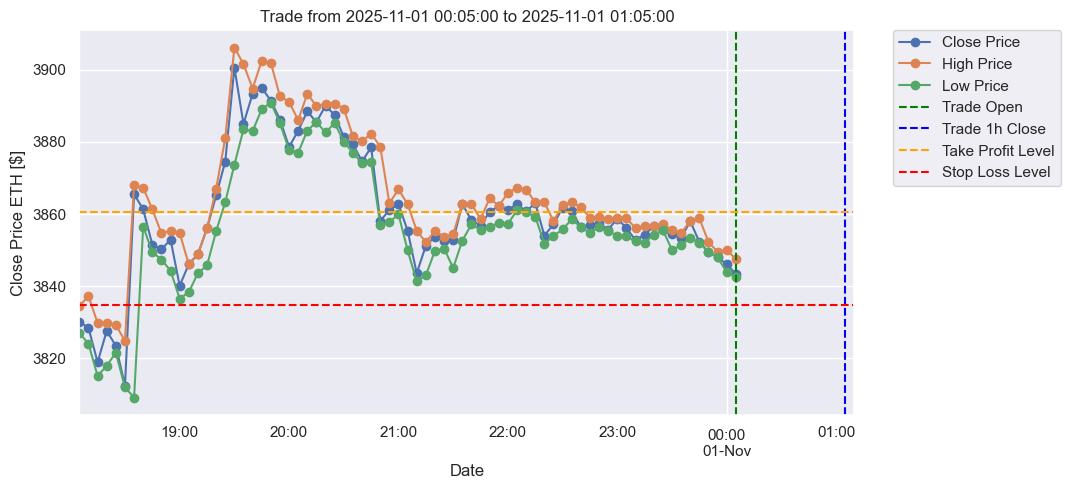

In [178]:
i_trade = 1
target_level = 0.0045
R = 2
date_open = date_index_test#df_trades[df_trades["type"] == "TP"]["date_open"].values[i_trade]
date_tp = date_index_test+pd.Timedelta(minutes=60) #df_trades[df_trades["type"] == "TP"].index[i_trade]

df_feat_plot["Close_ETH_raw"].loc[
    date_open - pd.Timedelta(minutes=5*PAST_HISTORY):date_tp + pd.Timedelta(minutes=5)
    ].plot(kind="line", figsize=(10,5), label="Close Price", marker="o")
(df_feat_plot["High_ETH"]).loc[date_open 
    - pd.Timedelta(minutes=5*PAST_HISTORY):date_tp + pd.Timedelta(minutes=5)].plot(
        kind="line", figsize=(10,5), label="High Price", marker="o"
    ) 
(df_feat_plot["Low_ETH"]).loc[date_open 
    - pd.Timedelta(minutes=5*PAST_HISTORY):date_tp + pd.Timedelta(minutes=5)].plot(
        kind="line", figsize=(10,5), label="Low Price", marker="o"
    )

plt.title(f"Trade from {date_open} to {date_tp}")
plt.axvline(x=date_open, color='green', linestyle='--', label='Trade Open')
plt.axvline(x=date_tp, color='blue', linestyle='--', label='Trade 1h Close')
# plot target_level line
price_open = df_feat_plot["Close_ETH_raw"].loc[date_open]
plt.axhline(y=price_open * (1 + target_level), color='orange', linestyle='--', label='Take Profit Level')
# plot SL line
plt.axhline(y=price_open * (1 - 1/R * target_level), color='red', linestyle='--', label='Stop Loss Level')
plt.xlabel("Date")
plt.ylabel("Close Price ETH [$]")
# legend outside graph
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# x range until date_tp + 5 min 
plt.xlim(date_open - pd.Timedelta(minutes=5*PAST_HISTORY), date_tp + pd.Timedelta(minutes=5))
plt.show()

In [161]:
try:
    elapsed = time.time() - __nb_start_time
    hours, rem = divmod(int(elapsed), 3600)
    minutes, seconds = divmod(rem, 60)
    print("\n✅ Notebook total execution time: {:02d}:{:02d}:{:02d} (hh:mm:ss)".format(hours, minutes, seconds))
    print("Total seconds: {:.2f}s".format(elapsed))
except NameError:
    print("⚠️  Start time variable '__nb_start_time' not found. Please run the 'Notebook start' cell at the top, then re-run the notebook to measure total execution time.")


✅ Notebook total execution time: 00:03:52 (hh:mm:ss)
Total seconds: 232.72s
